In [1]:
import pandas as pd 
import numpy as np
from IPython.display import Image as i
import seaborn as sns
import random 
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score,f1_score
from sklearn.ensemble import RandomForestClassifier
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm
from joblib import Parallel, delayed
import multiprocessing
from datetime import datetime
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
oov_token = '<gta>'
import warnings
warnings.filterwarnings("ignore")

import pathlib
import tensorflow as tf

import pickle
from tensorflow.keras.layers import Dense,Input,Activation,Dropout,Flatten,BatchNormalization,Concatenate,LSTM,Conv1D,MaxPool1D
from tensorflow.keras.models import Model
import datetime
from tensorflow.keras.regularizers import l2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import gc 
import pickle

from tensorflow.keras.callbacks import Callback,ReduceLROnPlateau,EarlyStopping,ModelCheckpoint
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score,roc_auc_score
import os
from tensorflow.keras.layers import Embedding
from IPython.display import Image as i
import os
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"]="true"
from sklearn.model_selection import train_test_split
import xgboost

# LOADING THE TABLES

In [26]:
df6=pd.read_csv('order_products__prior.csv')
print(df6.columns)
print(df6.info())
print(df6.shape)
df6.head()

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB
None
(32434489, 4)


,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
df=pd.read_csv('order_products__train.csv')
print(df.columns)
print(df.info())
print(df.shape)
df.head()

Index(['order_id', 'product_id', 'add_to_cart_order', 'reordered'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB
None
(1384617, 4)


,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [3]:
df['reordered'].isnull().any()

False

In [9]:
df1=pd.read_csv('orders.csv')
print(df1.columns)
print(df1.info())
print(df1.shape)
df1.head()

Index(['order_id', 'user_id', 'eval_set', 'order_number', 'order_dow',
       'order_hour_of_day', 'days_since_prior_order'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
None
(3421083, 7)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [17]:
df2=pd.read_csv('products.csv')
print(df2.columns)
print(df2.info())
print(df2.shape)

df2.head()

Index(['product_id', 'product_name', 'aisle_id', 'department_id'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None
(49688, 4)


,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [17]:
df3=pd.read_csv('departments.csv')
print(df3.columns)
print(df3.info())
print(df3.shape)
df3.head()

Index(['department_id', 'department'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 464.0+ bytes
None
(21, 2)


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [116]:
df4=pd.read_csv('aisles.csv')
print(df4.columns)
print(df4.info())
print(df4.shape)
df4.head()

Index(['aisle_id', 'aisle'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None
(134, 2)


,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [22]:
df7=pd.read_csv('sample_submission.csv')
print(df7.columns)
print(df7.info())
print(df7.shape)
df7.head()

Index(['order_id', 'products'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75000 entries, 0 to 74999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   order_id  75000 non-null  int64 
 1   products  75000 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB
None
(75000, 2)


,order_id,products
0,17,39276 29259
1,34,39276 29259
2,137,39276 29259
3,182,39276 29259
4,257,39276 29259


# RELATIONSHIP DIAGRAM

In [33]:
i(filename="C:/Users/Abhi/Desktop/self study/instacart_files.png")

In [34]:
products=pd.merge(df2,df3,on='department_id',how='inner')
products=pd.merge(products,df4,on='aisle_id',how='inner')


# Product Aisle Department table

In [35]:
products=products.drop(['department_id','aisle_id'],axis=1)
products.head()

,product_id,product_name,department,aisle
0,1,Chocolate Sandwich Cookies,snacks,cookies cakes
1,78,Nutter Butter Cookie Bites Go-Pak,snacks,cookies cakes
2,102,Danish Butter Cookies,snacks,cookies cakes
3,172,Gluten Free All Natural Chocolate Chip Cookies,snacks,cookies cakes
4,285,Mini Nilla Wafers Munch Pack,snacks,cookies cakes


# Order -order_product table

In [36]:
opo_prior=pd.merge(df6,df1[df1['eval_set']=='prior'],on='order_id',how='inner')
opo=pd.merge(opo_prior,products,on='product_id',how='inner')
opo=opo.sort_values(by=['user_id','order_number'])
opo.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,department,aisle
3059124,2539329,196,1,0,1,prior,1,2,8,NaN,Soda,beverages,soft drinks
13389957,2539329,14084,2,0,1,prior,1,2,8,NaN,Organic Unsweetened Vanilla Almond Milk,dairy eggs,soy lactosefree
17764526,2539329,26088,4,0,1,prior,1,2,8,NaN,Aged White Cheddar Popcorn,snacks,popcorn jerky
21552934,2539329,12427,3,0,1,prior,1,2,8,NaN,Original Beef Jerky,snacks,popcorn jerky
28226758,2539329,26405,5,0,1,prior,1,2,8,NaN,XL Pick-A-Size Paper Towel Rolls,household,paper goods


In [38]:
opo_train=pd.merge(df,df1[df1['eval_set']=='train'],on='order_id',how='inner')
opo_train=pd.merge(opo_train,products,on='product_id',how='inner')
opo_train=opo_train.sort_values(by=['user_id','order_number'])
opo_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,department,aisle
31620,1187899,49235,10,1,1,train,11,4,8,14.0,Organic Half & Half,dairy eggs,cream
232987,1187899,46149,11,1,1,train,11,4,8,14.0,Zero Calorie Cola,beverages,soft drinks
233810,1187899,196,1,1,1,train,11,4,8,14.0,Soda,beverages,soft drinks
275960,1187899,27845,9,0,1,train,11,4,8,14.0,Organic Whole Milk,dairy eggs,milk
516717,1187899,38928,3,1,1,train,11,4,8,14.0,0% Greek Strained Yogurt,dairy eggs,yogurt


In [17]:
gta=pd.concat([opo_prior,opo_train])

In [18]:
gta.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 33819106 entries, 3059124 to 1036377
Data columns (total 13 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   product_id              int64  
 2   add_to_cart_order       int64  
 3   reordered               int64  
 4   user_id                 int64  
 5   eval_set                object 
 6   order_number            int64  
 7   order_dow               int64  
 8   order_hour_of_day       int64  
 9   days_since_prior_order  float64
 10  product_name            object 
 11  department              object 
 12  aisle                   object 
dtypes: float64(1), int64(8), object(4)
memory usage: 3.5+ GB


In [2]:
def reduce_mem_usage(props):                                           #https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
    start_mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in props.columns:
        if props[col].dtype != object:  # Exclude strings
            
            # Print current column type
            print("******************************")
            print("Column: ",col)
            print("dtype before: ",props[col].dtype)
            
            # make variables for Int, max and min
            IsInt = False
            mx = props[col].max()
            mn = props[col].min()
            
            # Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(props[col]).all(): 
                NAlist.append(col)
                props[col].fillna(mn-1,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = props[col].fillna(0).astype(np.int64)
            result = (props[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        props[col] = props[col].astype(np.uint8)
                    elif mx < 65535:
                        props[col] = props[col].astype(np.uint16)
                    elif mx < 4294967295:
                        props[col] = props[col].astype(np.uint32)
                    else:
                        props[col] = props[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        props[col] = props[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        props[col] = props[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        props[col] = props[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        props[col] = props[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                props[col] = props[col].astype(np.float32)
            
            # Print new column type
            print("dtype after: ",props[col].dtype)
            print("******************************")
    
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = props.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return props, NAlist

In [3]:
gta=pd.read_csv('full.csv')

In [4]:
gta.pop('Unnamed: 0')
gta.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,department,aisle
0,2539329,196,1,0,1,prior,1,2,8,255,Soda,beverages,soft drinks
1,2539329,14084,2,0,1,prior,1,2,8,255,Organic Unsweetened Vanilla Almond Milk,dairy eggs,soy lactosefree
2,2539329,26088,4,0,1,prior,1,2,8,255,Aged White Cheddar Popcorn,snacks,popcorn jerky
3,2539329,12427,3,0,1,prior,1,2,8,255,Original Beef Jerky,snacks,popcorn jerky
4,2539329,26405,5,0,1,prior,1,2,8,255,XL Pick-A-Size Paper Towel Rolls,household,paper goods


In [5]:
full_df,na_list=reduce_mem_usage(gta)

Memory usage of properties dataframe is : 3354.2510528564453  MB
******************************
Column:  order_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  product_id
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  add_to_cart_order
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  reordered
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  order_number
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  order_dow
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  order_hour_of_day
dtype befor

In [6]:
if(full_df.duplicated().values.any() ): 
    print('duplicate values present ')
else:
    print("no duplicate rows")

no duplicate rows


In [8]:
full_df.isnull().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
department                0
aisle                     0
dtype: int64

In [9]:
full_df.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
department                0
aisle                     0
dtype: int64

#no nan or null values

# Read train

In [109]:
train =full_df[full_df['eval_set']=='train']

# Read prior

In [6]:
prior=full_df[full_df['eval_set']=='prior']

In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1384617 entries, 32434489 to 33819105
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   order_id                1384617 non-null  uint32
 1   product_id              1384617 non-null  uint16
 2   add_to_cart_order       1384617 non-null  uint8 
 3   reordered               1384617 non-null  uint8 
 4   user_id                 1384617 non-null  uint32
 5   eval_set                1384617 non-null  object
 6   order_number            1384617 non-null  uint8 
 7   order_dow               1384617 non-null  uint8 
 8   order_hour_of_day       1384617 non-null  uint8 
 9   days_since_prior_order  1384617 non-null  uint16
 10  product_name            1384617 non-null  object
 11  department              1384617 non-null  object
 12  aisle                   1384617 non-null  object
dtypes: object(4), uint16(2), uint32(2), uint8(5)
memory usage: 75.3+

 # ITS COMPUTE TIME / FEATURE ENGINEERING

In [10]:
def groupby_agg_features(df,list_of_columns,agg_dict,new_columns):
    new=df.copy()
    grouped=new.groupby(list_of_columns)
    stats=grouped.agg(agg_dict)
#     stats.columns = the_stats.columns.droplevel(0)
    stats.columns=new_columns
    stats.reset_index(inplace=True)
    return stats

# By User 

In [18]:
agg_dict={'order_number':['max'],'days_since_prior_order':['mean'],'order_dow':['mean'],          #prior
'order_hour_of_day':['mean']}
doh=groupby_agg_features(prior,['user_id'],agg_dict
                     ,['max_order_tot',
                        'user_mean_days_since_prior_orders',
                        'user_mean_order_dow',
                        'user_mean_order_hour_of_day'])

doh.head()

,user_id,max_order_tot,user_mean_days_since_prior_orders,user_mean_order_dow,user_mean_order_hour_of_day
0,1,10,40.152542,2.644068,10.542373
1,2,14,31.902564,2.005128,10.441026
2,3,12,39.159091,1.011364,16.352273
3,4,5,68.611111,4.722222,13.111111
4,5,4,86.000000,1.621622,15.729730


# User reorder ratio 

In [25]:
h=np.unique(prior['user_id'])
print(h.shape)

(206209,)


In [78]:
import threading 

c=datetime.now()                       #prior
def func1():
    reordered=[]
    for x in h[:51552]:
        reordered.append(d[(d['reordered']==1) & (d['user_id']==x)].agg('count')[1])
    df=pd.DataFrame(reordered,columns=['count'])
    df.to_csv('1.csv')
def func2():
    reordered=[]
    for x in (h[51552:103104]):
        reordered.append(d[(d['reordered']==1) & (d['user_id']==x)].agg('count')[1])
    df=pd.DataFrame(reordered,columns=['count'])
    df.to_csv('2.csv')
def func3():
    reordered=[]
    for x in (h[103104:154656]):
        reordered.append(d[(d['reordered']==1) & (d['user_id']==x)].agg('count')[1])
    df=pd.DataFrame(reordered,columns=['count'])
    df.to_csv('3.csv')
def func4():
    reordered=[]
    for x in (h[154656:]):
        reordered.append(d[(d['reordered']==1) & (d['user_id']==x)].agg('count')[1])
    df=pd.DataFrame(reordered,columns=['count'])
    df.to_csv('4.csv')
t1=threading.Thread(target= func1 )

t2=threading.Thread(target= func2 )

t3=threading.Thread(target= func3 )

t4=threading.Thread(target= func4 )
t1.start()
t2.start()
t3.start()
t4.start()
t1.join()
t2.join()
t3.join()
t4.join()
print(datetime.now()-c)

2:06:08.828470


In [51]:
d=train

In [53]:
df1=pd.read_csv('1.csv')
df2=pd.read_csv('2.csv')

df3=pd.read_csv('3.csv')
df4=pd.read_csv('4.csv')

reorder_ratio=pd.concat([df1,df2,df3,df4])
reorder_ratio.pop('Unnamed: 0')
reorder_ratio['user_id']=h
reorder_ratio.head()
reorder_ratio['reorder_ratio']=[x/y for x,y in zip(reorder_ratio['count'],prior.groupby(prior['user_id']).agg({'order_number':max})['order_number'])]


In [94]:
reorder_ratio.to_csv('reorder_ratio.csv')

In [12]:
reorder_ratio=pd.read_csv('reorder_ratio.csv')
reorder_ratio.pop('Unnamed: 0')
reorder_ratio.head()

,count,user_id,reorder_ratio
0,41,1,4.100000
1,93,2,6.642857
2,55,3,4.583333
3,1,4,0.200000
4,14,5,3.500000


In [55]:
agg_dict2={'product_id':['count',lambda x : x.nunique()]}
rp=groupby_agg_features(prior,['user_id'],agg_dict2,['user_total_prod'
                        ,'user_unique_product'])


In [25]:
rp['average_basket_size']=rp['user_total_prod']/doh['max_order_tot']
rp.head()

,user_id,user_total_prod,user_unique_product,average_basket_size
0,1,59,18,5.900000
1,2,195,102,13.928571
2,3,88,33,7.333333
3,4,18,17,3.600000
4,5,37,23,9.250000


In [28]:
users=pd.merge(doh,rp,on='user_id',how='inner')
users=pd.merge(users,reorder_ratio,on='user_id',how='inner')
users.head()                                                                # prior

,user_id,max_order_tot,user_mean_days_since_prior_orders,user_mean_order_dow,user_mean_order_hour_of_day,user_total_prod,user_unique_product,average_basket_size,count,reorder_ratio
0,1,10,40.152542,2.644068,10.542373,59,18,5.900000,41,4.100000
1,2,14,31.902564,2.005128,10.441026,195,102,13.928571,93,6.642857
2,3,12,39.159091,1.011364,16.352273,88,33,7.333333,55,4.583333
3,4,5,68.611111,4.722222,13.111111,18,17,3.600000,1,0.200000
4,5,4,86.000000,1.621622,15.729730,37,23,9.250000,14,3.500000


# Products

In [13]:
prior.loc[:,'_user_buy_product_times'] = prior.groupby(['user_id', 'product_id']).cumcount() + 1

C:\Users\Abhi\anaconda3\lib\site-packages\pandas\core\indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
C:\Users\Abhi\anaconda3\lib\site-packages\pandas\core\indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [11]:
agg_dict3={'user_id':['count'],'reordered':['sum'],
'_user_buy_product_times':[lambda x: sum(x==1), lambda x: sum(x==2)]}
uru=groupby_agg_features(prior,['product_id'],agg_dict3,['prod_tot_cnts'
                        ,'prod_reorder_cnts','buy_1time','buy_2time'])
uru.head()

,product_id,prod_tot_cnts,prod_reorder_cnts,buy_1time,buy_2time
0,1,1852,1136.0,716,276
1,2,90,12.0,78,8
2,3,277,203.0,74,36
3,4,329,147.0,182,64
4,5,15,9.0,6,4


In [12]:
uru['prod_reorder_prob']=uru['buy_2time']/uru['buy_1time']
uru['prod_reorder_ratio']=uru['prod_reorder_cnts']/uru['prod_tot_cnts']
uru['prod_reorder_times']=uru['prod_reorder_cnts']/uru['buy_1time']
uru.head()
uru.to_csv('my_product.csv')

In [13]:
uru.head()

,product_id,prod_tot_cnts,prod_reorder_cnts,buy_1time,buy_2time,prod_reorder_prob,prod_reorder_ratio,prod_reorder_times
0,1,1852,1136.0,716,276,0.385475,0.613391,1.586592
1,2,90,12.0,78,8,0.102564,0.133333,0.153846
2,3,277,203.0,74,36,0.486486,0.732852,2.743243
3,4,329,147.0,182,64,0.351648,0.446809,0.807692
4,5,15,9.0,6,4,0.666667,0.600000,1.500000


In [16]:
agg_dict_4={'order_number':['count','min','max'],'add_to_cart_order':['mean']}
OC=groupby_agg_features(prior,['user_id','product_id'],agg_dict_4,['order_count'
                        ,'order_first','order_last','avg_cart_pos'])
OC.head()

,user_id,product_id,order_count,order_first,order_last,avg_cart_pos
0,1,196,10,1,10,1.400000
1,1,10258,9,2,10,3.333333
2,1,10326,1,5,5,5.000000
3,1,12427,10,1,10,3.300000
4,1,13032,3,2,10,6.333333


In [89]:
OC.to_csv('database.csv')

In [20]:
users=pd.read_csv('users.csv')
users.pop('Unnamed: 0')
up=OC.merge(uru,how='inner',on='product_id').merge(users,how='inner',on='user_id')       # prior 

In [29]:
up.head() # prior

,user_id,product_id,order_count,order_first,order_last,avg_cart_pos,prod_tot_cnts,prod_reorder_cnts,buy_1time,buy_2time,...,prod_reorder_times,max_order_tot,user_mean_days_since_prior_orders,user_mean_order_dow,user_mean_order_hour_of_day,user_total_prod,user_unique_product,average_basket_size,count,reorder_ratio
0,1,196,1,11,11,1,1507,1221.0,1507,0,...,0.810219,11,14,4,8,11,11,1.0,10,1.0
1,1,10258,1,11,11,6,104,78.0,104,0,...,0.750000,11,14,4,8,11,11,1.0,10,1.0
2,1,13032,1,11,11,7,153,116.0,153,0,...,0.758170,11,14,4,8,11,11,1.0,10,1.0
3,1,25133,1,11,11,2,186,139.0,186,0,...,0.747312,11,14,4,8,11,11,1.0,10,1.0
4,1,26088,1,11,11,8,136,77.0,136,0,...,0.566176,11,14,4,8,11,11,1.0,10,1.0


In [22]:
up.columns

Index(['user_id', 'product_id', 'order_count', 'order_first', 'order_last',
       'avg_cart_pos', 'prod_tot_cnts', 'prod_reorder_cnts', 'buy_1time',
       'buy_2time', 'prod_reorder_prob', 'prod_reorder_ratio',
       'prod_reorder_times', 'max_order_tot',
       'user_mean_days_since_prior_orders', 'user_mean_order_dow',
       'user_mean_order_hour_of_day', 'user_total_prod', 'user_unique_product',
       'average_basket_size', 'count', 'reorder_ratio'],
      dtype='object')

In [23]:
up['up_order_rate']=up['order_count']/up['max_order_tot']                         #Prior
up['_up_order_since_last_order']=up['max_order_tot']-up['order_last']
up['_up_order_rate_since_first_order']=up['order_count']/(up['max_order_tot']-up['order_first']+1)

In [24]:
up.head()

,user_id,product_id,order_count,order_first,order_last,avg_cart_pos,prod_tot_cnts,prod_reorder_cnts,buy_1time,buy_2time,...,user_mean_order_dow,user_mean_order_hour_of_day,user_total_prod,user_unique_product,average_basket_size,count,reorder_ratio,up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order
0,1,196,10,1,10,1.400000,35791,27791.0,8000,4660,...,2.644068,10.542373,59,18,5.9,41,4.1,1.0,0,1.000000
1,1,10258,9,2,10,3.333333,1946,1389.0,557,308,...,2.644068,10.542373,59,18,5.9,41,4.1,0.9,0,1.000000
2,1,10326,1,5,5,5.000000,5526,3603.0,1923,1003,...,2.644068,10.542373,59,18,5.9,41,4.1,0.1,5,0.166667
3,1,12427,10,1,10,3.300000,6476,4797.0,1679,889,...,2.644068,10.542373,59,18,5.9,41,4.1,1.0,0,1.000000
4,1,13032,3,2,10,6.333333,3751,2465.0,1286,617,...,2.644068,10.542373,59,18,5.9,41,4.1,0.3,0,0.333333


In [25]:
up.to_csv('features.csv')

In [86]:
up.isna().sum()

user_id                              0
product_id                           0
order_count                          0
order_first                          0
order_last                           0
avg_cart_pos                         0
prod_tot_cnts                        0
prod_reorder_cnts                    0
buy_1time                            0
buy_2time                            0
prod_reorder_prob                    0
prod_reorder_ratio                   0
prod_reorder_times                   0
max_order_tot                        0
user_mean_days_since_prior_orders    0
user_mean_order_dow                  0
user_mean_order_hour_of_day          0
user_total_prod                      0
user_unique_product                  0
average_basket_size                  0
count                                0
reorder_ratio                        0
up_order_rate                        0
_up_order_since_last_order           0
_up_order_rate_since_first_order     0
dtype: int64

 # EDA

% age reordered in train data = 0.5985944127509629
% age reordered in prior data = 0.5896974667922161


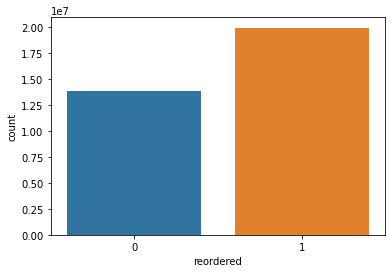

In [186]:
print("% age reordered in train data =",full_df[(full_df['eval_set']=='train') & (full_df['reordered']==1)].shape[0]/full_df[full_df['eval_set']=='train'].shape[0])
print("% age reordered in prior data =",full_df[(full_df['eval_set']=='prior') & (full_df['reordered']==1)].shape[0]/full_df[full_df['eval_set']=='prior'].shape[0])
sns.countplot(full_df['reordered'])

In [19]:
df=prior.groupby('user_id')
dict1={}
dict2={}
for _,grps in tqdm(df):
    
    UP = grps.pivot(index='order_id',columns='product_id',values='reordered').fillna(0)  #1 if order id contains product else 0
    x=UP.values
    list1=[]
    for y in range(x.shape[0]):   # if all are 0 then sum of entire row should be 0  which means nothing is reordered
        if sum(x[y])==0:
            list1.append(UP.index[y])
    if len(list1)!=0:
        dict1[grps.user_id.values[0]]=list1
#     if len(list1)==x.shape[1]:
#         dict1[grps.user_id.values[0]]=list1
count_prior=0
for values in dict1.values():
    count_prior=count_prior+len(values)
print('no of orders with no reordered in prior =',count_prior)

train=full_df[full_df['eval_set']=='train']
df=train.groupby('user_id')
dict1={}
dict2={}
for _,grps in tqdm(df):
    
    UP = grps.pivot(index='order_id',columns='product_id',values='reordered').fillna(0)
    x=UP.values
    list1=[]
    for y in range(x.shape[0]):
        if sum(x[y])==0:
            list1.append(UP.index[y])
    if len(list1)!=0:
        dict1[grps.user_id.values[0]]=list1
#     if len(list1)==x.shape[1]:
#         dict1[grps.user_id.values[0]]=list1
count_train=0
for values in dict1.values():
    count_train=count_train+len(values)
print(' no of orderes with no reordered product in train =',count_train)

100%|█████████████████████████████████████████████████████████████████████████| 206209/206209 [07:52<00:00, 436.55it/s]


no of orders with no reordered in prior = 388513


100%|█████████████████████████████████████████████████████████████████████████| 131209/131209 [03:56<00:00, 554.38it/s]

 no of orderes with no reordered product in train = 8602


#Both train and prior data are equi distributed in terms of no of reordered 

#these No reordered order id needs to be predicted explicit NA 

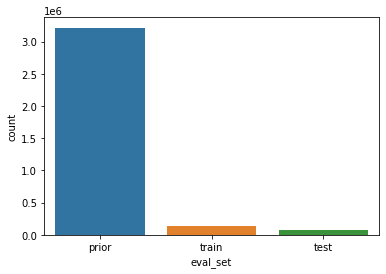

In [47]:
sns.countplot(df1['eval_set'])

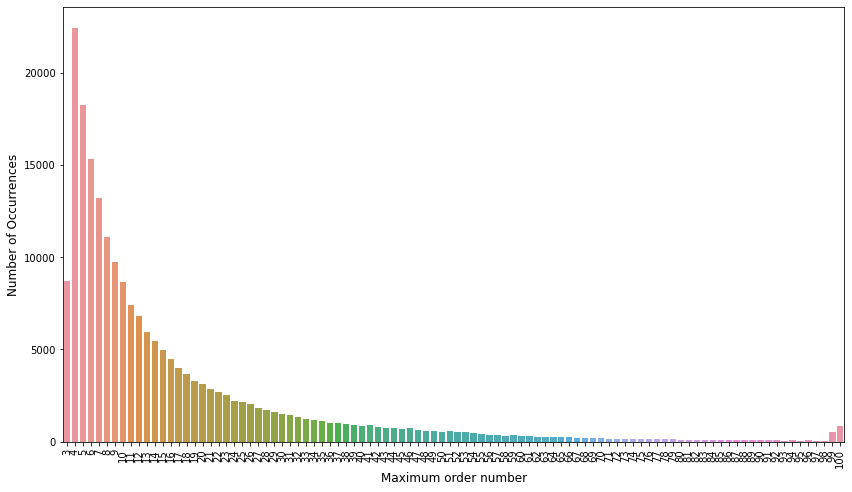

In [174]:
t=full_df.groupby(['user_id']).agg({'order_number':'max'})
t.columns=['order_number']
t.reset_index(inplace=True)
plt.figure(figsize=(14,8))
sns.countplot(t['order_number'])
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel('Maximum order number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

seems like there are quiet a few people with order no =3 this goes against the claim of each user having atleast 4 orders 

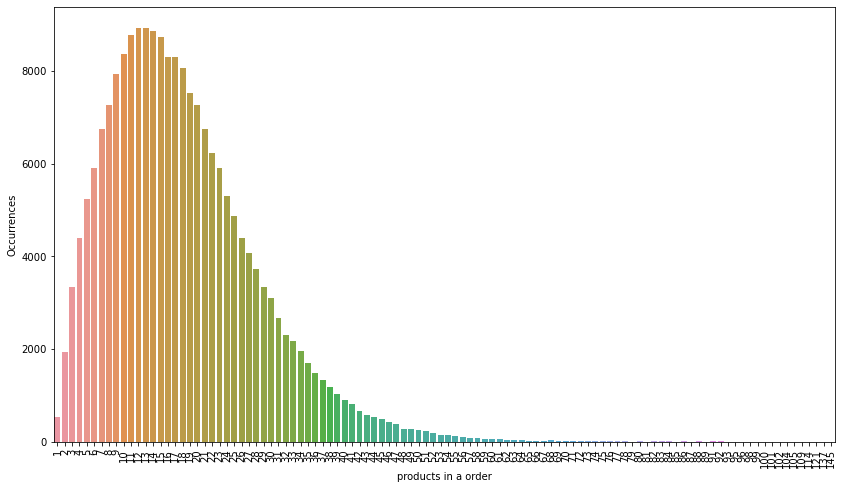

In [10]:
t=full_df.groupby(['user_id']).agg({'add_to_cart_order':'max'})
t.columns=['add_to_cart_order']
t.reset_index(inplace=True)
plt.figure(figsize=(14,8))
sns.countplot(t['add_to_cart_order'])
plt.ylabel('Occurrences')
plt.xlabel('products in a order')
plt.xticks(rotation='vertical')
plt.show()

# people  who buy same thing again and again 

In [7]:
orders = df1.groupby(['user_id']).agg({'order_number':['count']})
orders.columns=orders.columns.droplevel(0)
orders.columns=['order_number']
orders.reset_index(inplace=True)
orders[orders['order_number']>6]

prior=pd.read_csv('order_products__prior.csv')
orders = pd.merge(df1,orders['user_id'], how='right', on="user_id")
prior = pd.merge(prior,orders, how='inner', on="order_id")
prior = prior[['user_id', 'product_id', 'order_number']]
prior.head()

,user_id,product_id,order_number
0,202279,33120,3
1,202279,28985,3
2,202279,9327,3
3,202279,45918,3
4,202279,30035,3


# checking for people having orders >6 

In [93]:
user_groups=prior[prior['user_id']==54035].groupby('user_id')
dict1={}
for _,grp in user_groups:
    grp.user_id = 1
    UP = grp.pivot(index="product_id", columns='order_number').fillna(-1)
    UP.columns = UP.columns.droplevel(0)

    x=UP.values
    UP.reset_index(inplace=True)

    for i in range(x.shape[0]) :
        if sum(x[i])==x.shape[1]:
            name=df2.loc[UP['product_id'][i]-1]['product_name']
            print('prodects being reordered all the times are ',UP['product_id'][i],'name is ',name  )
      
        elif  sum(x[i])==x.shape[1]-2 :
             unordered=df2.loc[UP['product_id'][i]-1]['product_name']
             list1=[]
             print('product with almost all the time reordered',df2.loc[UP['product_id'][i]-1]['product_name'])
#              temp=0
             for g in range(x[i].shape[0]):
                    if x[i][g] !=1:
#                         temp=g
                        break
             
             for i in range(UP[g+1].shape[0]):
                    if UP[g+1][i]==1:
                        list1.append(df2.loc[UP['product_id'][i]-1]['product_name'])
            
    dict1[unordered]=list1
    break
                        
   

product with almost all the time reordered Cola


In [91]:
dict1

{'Cola': ['Reduced Fat Swiss Deli-Thin Slices Cheese',
  'Original Whole Grain English Muffins',
  'Low-Fat Strawberry Banana on the Bottom Greek Yogurt',
  'Fridge Pack Cola',
  '24/7 Performance Light Weight Cat Litter',
  'Lowfat 1% Milk',
  'Strawberry on the Bottom Nonfat Greek Yogurt']}

# Observation :-
    1 Here we see that the person didnt order cola(which was his goto or ordered all the time product) but ordered fridge cola

# USERS

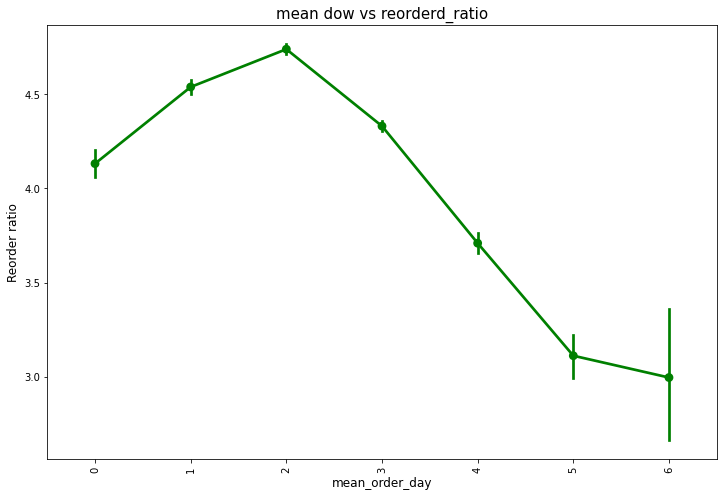

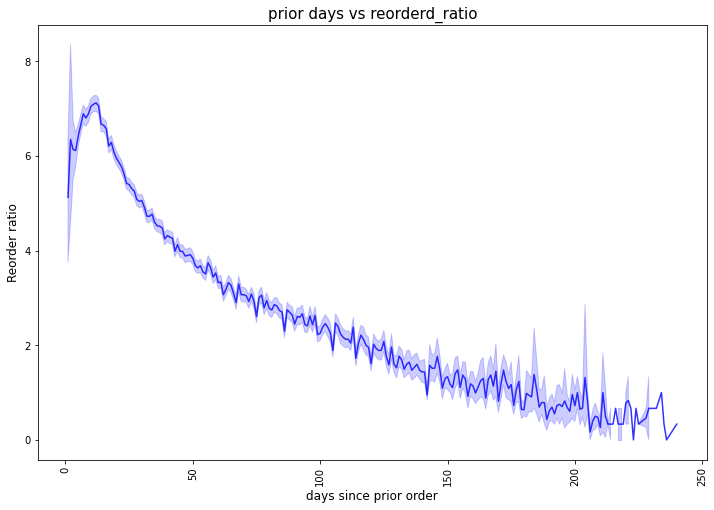

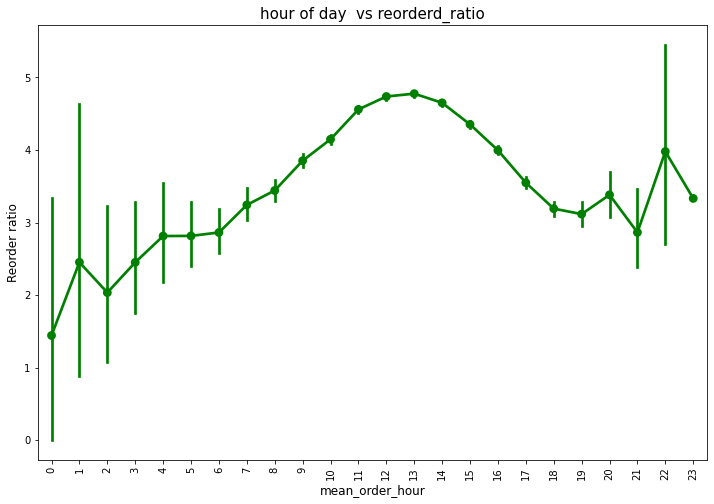

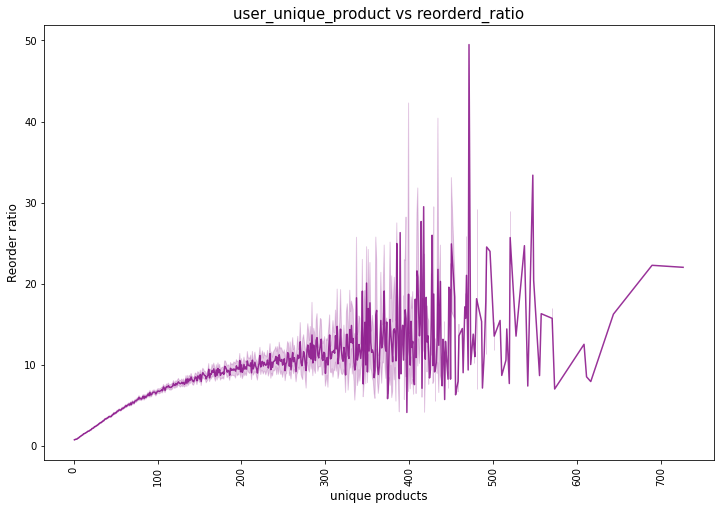

In [96]:
users=pd.read_csv('users.csv')
y=users.pop('Unnamed: 0')


plt.figure(figsize=(12,8))
sns.pointplot([int(i) for i in users['user_mean_order_dow'].values], (users['reorder_ratio'].values), alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('mean_order_day', fontsize=12)
plt.title("mean dow vs reorderd_ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.lineplot([int(i) for i in users['user_mean_days_since_prior_orders'].values], (users['reorder_ratio'].values), alpha=0.8, color=color[1])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('days since prior order', fontsize=12)
plt.title("prior days vs reorderd_ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.pointplot([int(i) for i in users['user_mean_order_hour_of_day'].values], (users['reorder_ratio'].values), alpha=0.8, color=color[2])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('mean_order_hour', fontsize=12)
plt.title("hour of day  vs reorderd_ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

plt.figure(figsize=(12,8))
sns.lineplot([int(i) for i in users['user_unique_product'].values], (users['reorder_ratio'].values), alpha=0.8, color=color[3])
plt.ylabel('Reorder ratio', fontsize=12)
plt.xlabel('unique products', fontsize=12)
plt.title("user_unique_product vs reorderd_ratio", fontsize=15)
plt.xticks(rotation='vertical')
plt.show()

# Observation :
    1 reorder ratio highest from day 0 to 3 then goes down really fast 
    2 reorder ratio decreases once days since prior order passes 20 days 
    3 reorder ratio is the highest in from hours 10-13 
    4 reorder ratio increases ast the unique products increases quite steadily but then shows abrupt pattern of highs and lows after 300 mark

# PRODUCT

In [105]:
cnt_srs = prior['product_name'].value_counts().reset_index().head(100)
cnt_srs.columns = ['product_name', 'frequency_count']
cnt = prior[prior['reordered']==1]['product_name'].value_counts().reset_index().head(100)
cnt.columns = ['product_name', 'frequency_count']
cnt['frequency_%']=(cnt.frequency_count/cnt_srs.frequency_count)*100
cnt['total_count']=cnt_srs.frequency_count
cnt.head(20)

,product_name,frequency_count,frequency_%,total_count
0,Banana,398609,84.350089,472565
1,Bag of Organic Bananas,315913,83.255501,379450
2,Organic Strawberries,205845,77.770389,264683
3,Organic Baby Spinach,186884,77.250011,241921
4,Organic Hass Avocado,170131,79.655311,213584
5,Organic Avocado,134044,75.810310,176815
6,Organic Whole Milk,114510,75.011300,152657
7,Large Lemon,106255,74.329665,142951
8,Organic Raspberries,105409,74.956445,140627
9,Strawberries,99802,72.370110,137905


In [28]:
prior=prior.merge(df3,on='department',how= 'inner')

In [112]:
gta=prior.groupby(['order_hour_of_day','product_name'])['order_id'].agg('count').reset_index()

In [113]:
gta=gta.merge(cnt[['total_count','product_name']],on='product_name',how='inner')

In [114]:
gta.head()

,order_hour_of_day,product_name,order_id,total_count
0,0,100% Raw Coconut Water,326,45238
1,1,100% Raw Coconut Water,195,45238
2,2,100% Raw Coconut Water,114,45238
3,3,100% Raw Coconut Water,77,45238
4,4,100% Raw Coconut Water,67,45238


In [123]:
for _,grps in gta.groupby(['order_hour_of_day']):

   
    grps['%_of_product']=grps.order_id/grps.total_count*100
    print(grps.sort_values('%_of_product',ascending=False)[['order_hour_of_day','product_name','%_of_product']][:25])

      order_hour_of_day                   product_name  %_of_product
384                   0         Extra Virgin Olive Oil      0.997457
1176                  0            Organic Ginger Root      0.969565
1584                  0              Organic Red Onion      0.945916
1944                  0                      Red Onion      0.902795
1728                  0         Organic Tomato Cluster      0.881347
1488                  0           Organic Navel Orange      0.851224
936                   0           Organic Blackberries      0.835996
1008                  0               Organic Cilantro      0.827513
960                   0            Organic Blueberries      0.826714
1248                  0         Organic Grape Tomatoes      0.823730
336                   0               Clementines, Bag      0.820771
792                   0             Orange Bell Pepper      0.804756
1320                  0  Organic Italian Parsley Bunch      0.803670
1344                  0           

<ipython-input-123-e0be56f14f9f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-123-e0be56f14f9f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-123-e0be56f14f9f>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-123-e0b

# 1 this dataset  has  users who likes to eat healthy  with banan having the most ordered and very high % reordered for organic items 
# 2 well i was hoping to find some relation ships like as the the night approaches people eat more junk food but its repeating the same food for every hour of day

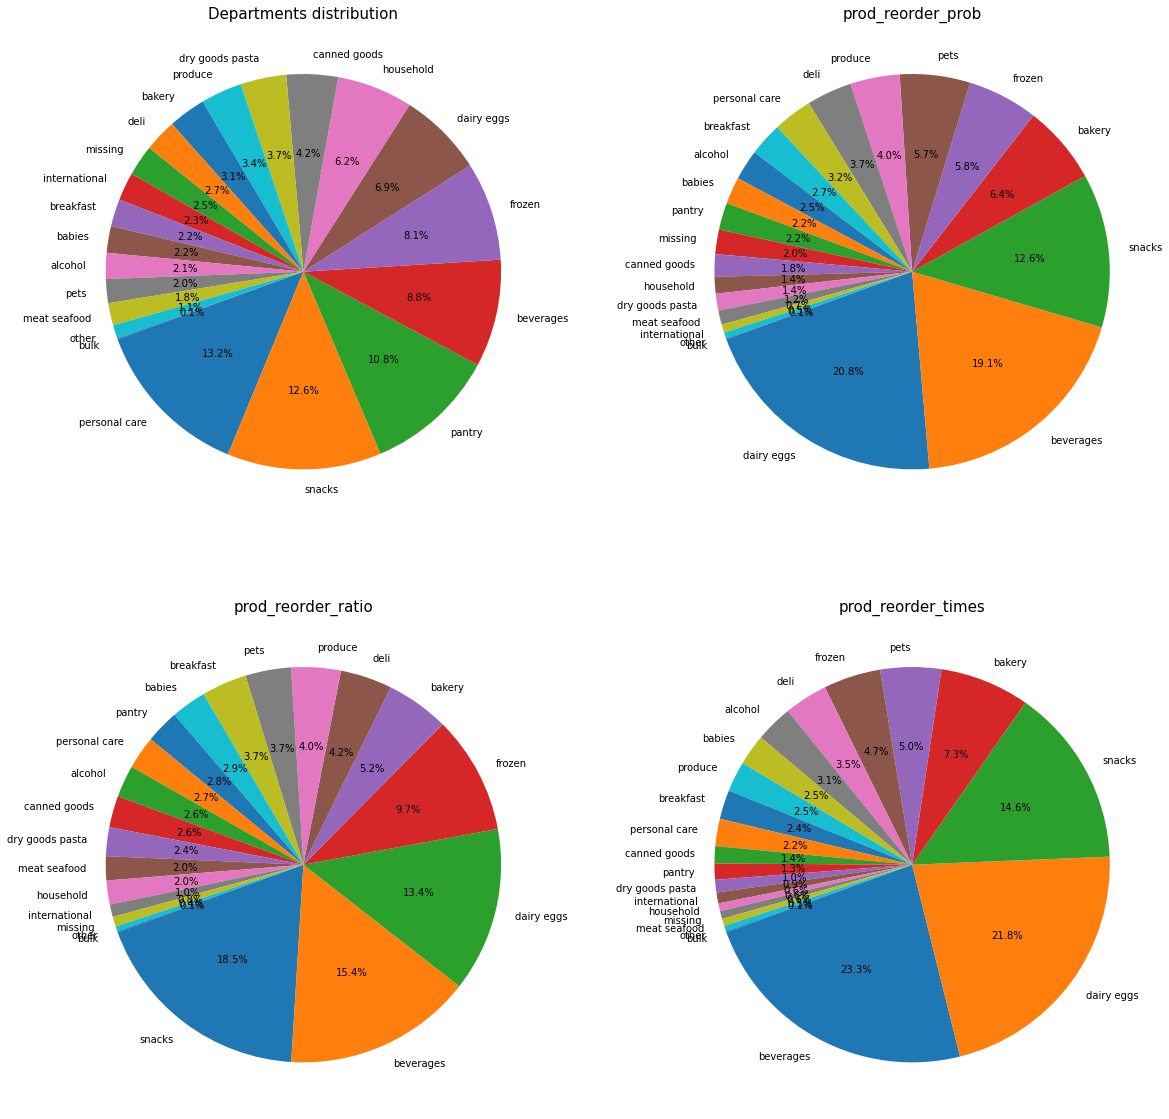

In [8]:
uru=pd.read_csv('my_product.csv')
uru.pop('Unnamed: 0')
df2=pd.read_csv('products.csv')
g=uru.merge(df2[['product_id','department_id','product_name']],on='product_id',how='inner').merge(df3,on='department_id',how='inner')
g.head()
clmns=['prod_reorder_prob','prod_reorder_ratio','prod_reorder_times']
f,arr = plt.subplots(2,2,sharex=True,figsize=(20,20))
temp_series = g['department'].value_counts()
labels = (np.array(temp_series.index))
sizes = (np.array((temp_series / temp_series.sum())*100))
arr[0,0].pie(sizes, labels=labels, 
        autopct='%1.1f%%', startangle=200)
arr[0,0].set_title("Departments distribution", fontsize=15)


x,y=[0,1],[0,1]
count=0
for j in x:
    for k in y:
        
        if j==0 and k==0 :
          
            continue
            
        if clmns[count]==clmns[2]:
             f=g[g[clmns[count]]>2]
        else:
            f=g[g[clmns[count]]>.5]
        temp_series = f['department'].value_counts()
        labels = (np.array(temp_series.index))
        sizes = (np.array((temp_series / temp_series.sum())*100))
        arr[j,k].pie(sizes, labels=labels, autopct='%1.1f%%', startangle=200)
       
        arr[j,k].set_title(clmns[count], fontsize=15)
        count+=1
        


# Observation:-
#1 department wise personal care is the most ordered department followed by snacks pantry and beverages
#2 different story when observing reorder stats 
                a. reorder prob of dairy eggs is the highest followed by beverages and snacks 
                b. reorder ratio pie, snacks dominated meaning reordering /total orders is very high 
                c reorder times meaning how many times that product per department is being reordered is highest in beverage
                

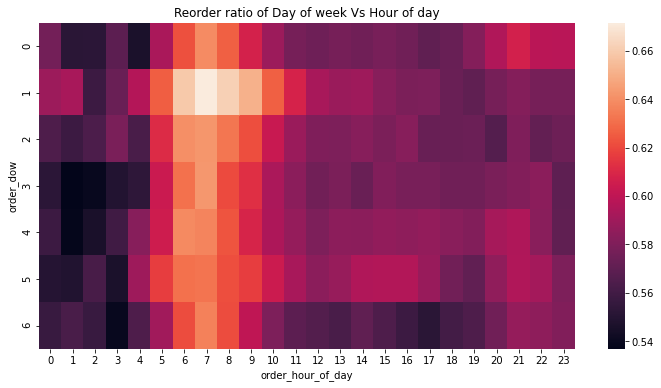

In [47]:
df = prior.groupby(["order_dow", "order_hour_of_day"]).agg({"reordered":"mean"}).reset_index()
df = df.pivot('order_dow', 'order_hour_of_day', 'reordered')

plt.figure(figsize=(12,6))
sns.heatmap(grouped_df)
plt.title("Reorder ratio of Day of week Vs Hour of day")
plt.show()


plot to show relation between reorder ratio and hour of day and day of week 

observations
   hours 5,6,7,8,9 are the hottest hours
   days  5 seems to be the hottest day followed by 0 and 1 

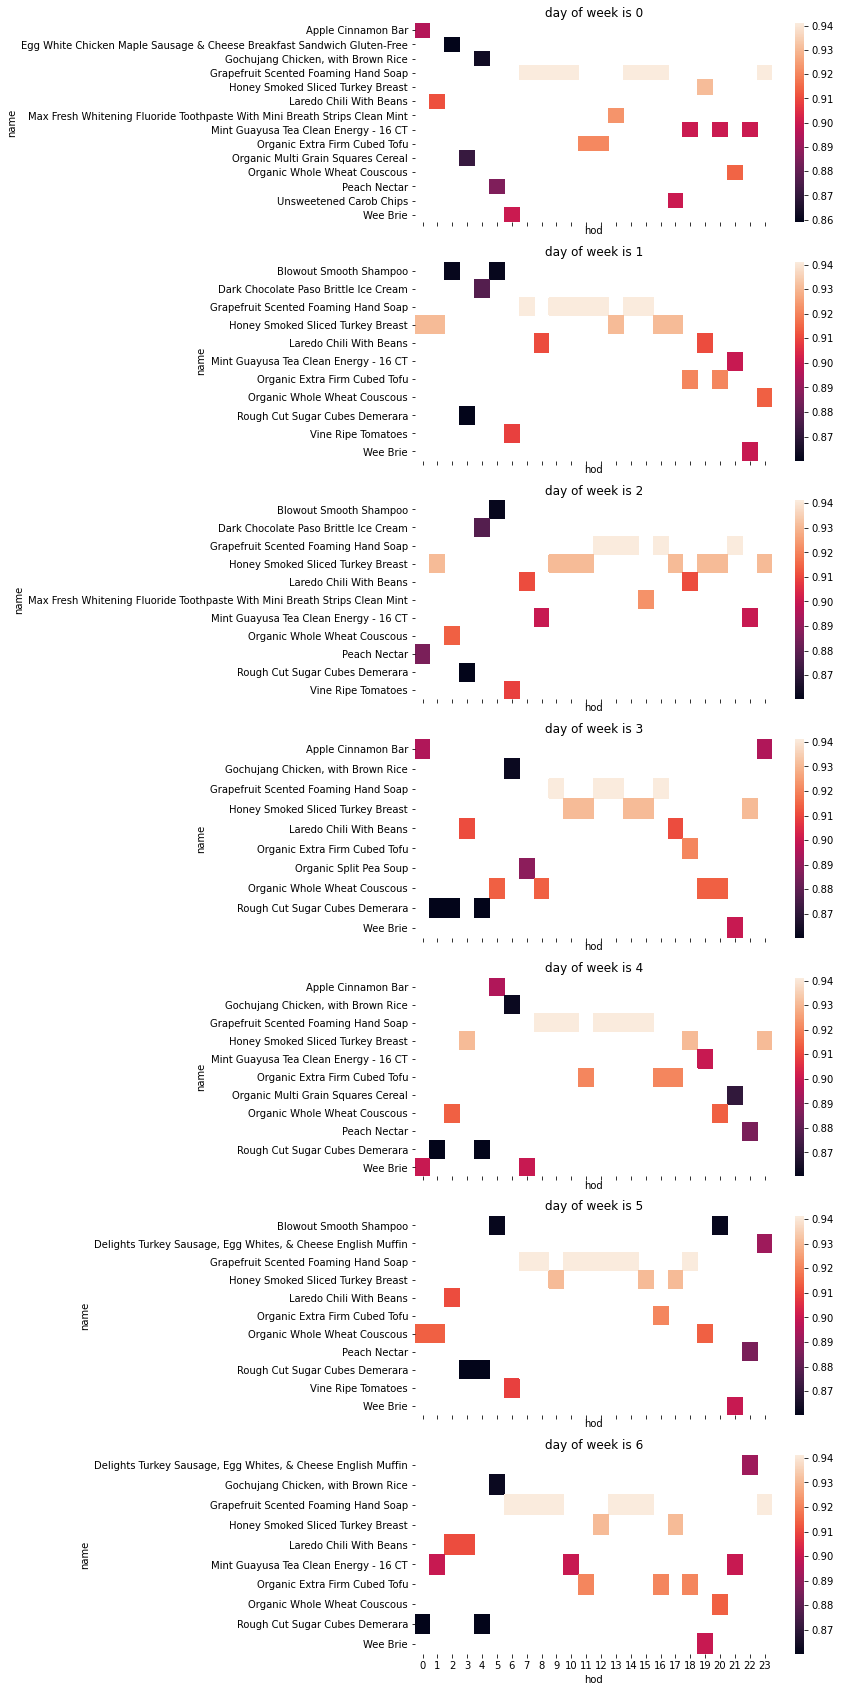

In [127]:
df=pd.read_csv('features.csv')
df.pop('Unnamed: 0')
prior=prior.merge(df[['user_id','product_id','prod_reorder_ratio']],on=['user_id','product_id'],how='inner')
prior,list1=reduce_mem_usage(prior)
prior.head()
df = prior.groupby(["order_dow", "order_hour_of_day",'product_id',]).agg({'prod_reorder_ratio':'max'}).reset_index()
dict1={}
for _,grps in df.groupby(["order_dow", "order_hour_of_day"]):
    max=0
    id=0
    for x,y in zip(grps['prod_reorder_ratio'],grps['product_id']):
        if max<x:
            id=y
            max=x
    dict1[(grps['order_dow'].iloc[1],grps[ "order_hour_of_day"].iloc[1])]=df2['product_name'].loc[id],max
  
    
list1=[]
list2=[]
list3=[]
list4=[]
dict2={}
for k,v in dict1.items():
    list1.append(v[0])
    list2.append(v[1])
    list3.append(k[0])
    list4.append(k[1])
dict2['order_dow']=list3
dict2['hod']=list4
dict2['name']=list1
dict2['ratio']=list2
bruh=pd.DataFrame(dict2)
bruh.head()    
# names=((np.asarray(bruh['name'])).reshape(7,24))
# labels=(np.asarray(["{0}".format(val) for val in names.flatten()])).reshape(7,24)
list1=[]
list2=[]
for i in range(0,168,24):
    list1.append(bruh[i:i+24].pivot('name', 'hod', 'ratio'))

f,arr = plt.subplots(7,1,sharex=True,figsize=(8,30))
for i in range(len(list1)):
    sns.heatmap(list1[i],ax=arr[i])
    arr[i].set_title('day of week is {}'.format(i))

plt.show()


plot to represent onm which day and which hour which product has the highest reorder ratio
these are 7 heatmaps of 7 days of week with x axis being hour of the day and y being the most reordered product of that time with bar representing reorder ratio

# 3D representation of above plot

In [141]:
import plotly.express as px
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
app = JupyterDash(__name__)

app.layout = html.Div([
    dcc.Graph(id="scatter-plot"),
    html.P("day of the week:"),
    dcc.RangeSlider(
        id='range-slider',
        min=0, max=6, step=1,
        marks={0: '0', 7: '6'},
        value=[0, 6]
    ),
])

@app.callback(
    Output("scatter-plot", "figure"), 
    [Input("range-slider", "value")])
def update_bar_chart(slider_range):
    low, high = slider_range
    mask = (bruh.order_dow >= low) & (bruh.order_dow <= high)

    fig = px.scatter_3d(bruh[mask], 
        x='order_dow', y='hod', z='ratio',
        color="ratio", hover_data=['name'])
    return fig
app.run_server(debug=True,mode='inline')

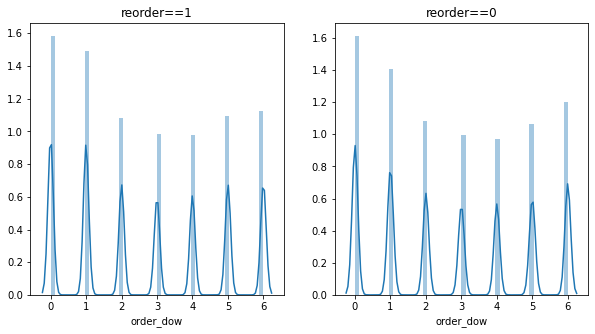

In [141]:
f,arr = plt.subplots(1,2,sharex=True,figsize=(10,5))
sns.distplot(prior['order_dow'].where(prior['reordered']==1).dropna(),ax=arr[0])
arr[0].set_title('reorder==1')
arr[1].set_title('reorder==0')
sns.distplot(prior['order_dow'].where(prior['reordered']==0).dropna(),ax=arr[1])

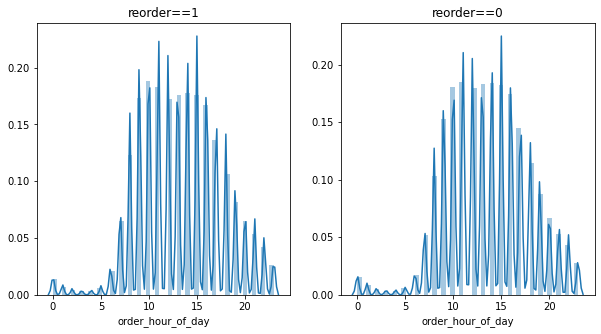

In [142]:
f,arr = plt.subplots(1,2,sharex=True,figsize=(10,5))
sns.distplot(prior['order_hour_of_day'].where(prior['reordered']==1).dropna(),ax=arr[0])
arr[0].set_title('reorder==1')
arr[1].set_title('reorder==0')
sns.distplot(prior['order_hour_of_day'].where(prior['reordered']==0).dropna(),ax=arr[1])

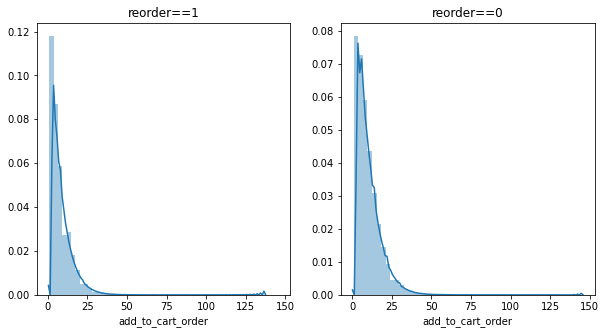

In [145]:
f,arr = plt.subplots(1,2,sharex=True,figsize=(10,5))
arr[0].set_title('reorder==1')
arr[1].set_title('reorder==0')
sns.distplot(prior['add_to_cart_order'].where(prior['reordered']==1).dropna(),ax=arr[0])
sns.distplot(prior['add_to_cart_order'].where(prior['reordered']==0).dropna(),ax=arr[1])

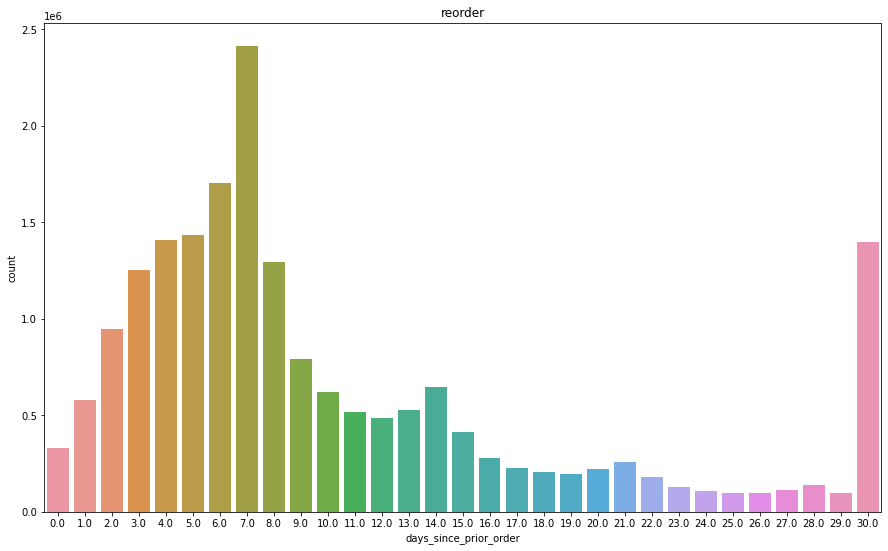

In [62]:
plt.figure(figsize=(15,9))
plt.title('reorder')

sns.countplot(prior['days_since_prior_order'].where(prior['reordered']==1).dropna())


Looks like customers order once in every week (check the peak at 7 days) or once in a month (peak at 30 days). We could also see smaller peaks at 14, 21 and 28 days (weekly intervals).

<AxesSubplot:title={'center':'reorder==0'}, xlabel='days_since_prior_order'>

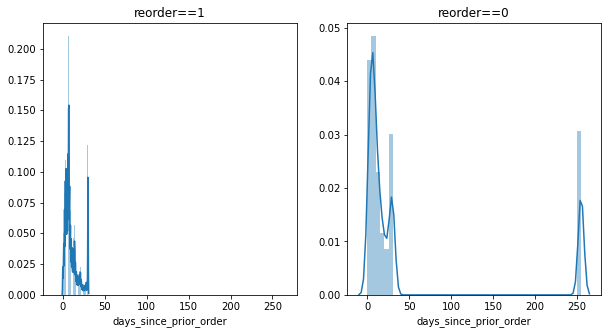

In [7]:
f,arr = plt.subplots(1,2,sharex=True,figsize=(10,5))
arr[0].set_title('reorder==1')
arr[1].set_title('reorder==0')
sns.distplot(prior['days_since_prior_order'].where(prior['reordered']==1).dropna(),ax=arr[0])
sns.distplot(prior['days_since_prior_order'].where(prior['reordered']==0).dropna(),ax=arr[1])

# Observations :- 
#1 max order hours between 10:00 and 15:00 no clear seperation between reordered or not reordered
#2 max days of order in a week 0 and 1 (labels are not given ) no clear seperation between reordered or not reordered
#3 add to cart d'snt show much significance in determining reordered or not ( no clear seperation between reordered or not)
#4 products prior ordered less than 30 are higher re-ordered and within that below 15 is a high peak and products prior 230 days sees a peek at reordered==0

# Cluster user into groups 

In [9]:
gta=np.unique(train['user_id'])

In [10]:
random_users_10k=random.sample([i for i in gta],30000)

In [11]:
users_random_users_10k=prior.iloc[random_users_10k]['user_id']
users_random_users_10k=pd.DataFrame(users_random_users_10k,columns=['user_id'])
users_random_users_10k=users_random_users_10k.merge(prior,on='user_id',how='inner')

In [12]:
users_random_users_10k.shape

(11791913, 13)

In [42]:
# with open('glove.6B.100d.txt', 'rb') as f:
# #     model = pickle.load(f)
#     glove_words =  set(f.keys())
embeddings_index={}
f=open('glove.6B.100d.txt','r',encoding='utf8')
for line in f:
    values = line.split()
    word = (values[0])

    coefs = np.asarray(values[1:], dtype='float32')

    embeddings_index[word] = coefs
    
f.close

<function TextIOWrapper.close()>

In [43]:
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [44]:
glove_words=embeddings_index.keys()


In [162]:
train.drop(train.tail(1).index,inplace=True)

In [168]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
tfidf_model = TfidfVectorizer()
tfidf_model.fit(train['aisle'])
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(tfidf_model.get_feature_names(), list(tfidf_model.idf_)))
tfidf_words = set(tfidf_model.get_feature_names())

In [169]:
X=train['aisle'].values

In [170]:
# average Word2Vec
# compute tfidf  word2vec for each review.
tfidf_w2v_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sentence in tqdm(X): # for each review/sentence
    vector = np.zeros(100) # as word vectors are of zero length
    tf_idf_weight =0; # num of words with a valid vector in the sentence/review
    for word in sentence.split(): # for each word in a review/sentence
        if (word in glove_words) and (word in tfidf_words):
            vec = embeddings_index[word] # getting the vector for each word
            # here we are multiplying idf value(dictionary[word]) and the tf value((sentence.count(word)/len(sentence.split())))
            tf_idf = dictionary[word]*(sentence.count(word)/len(sentence.split())) # getting the tfidf value for each word
            vector += (vec * tf_idf) # calculating tfidf weighted w2v
            tf_idf_weight += tf_idf
    if tf_idf_weight != 0:
        vector /= tf_idf_weight
    tfidf_w2v_vectors.append(vector)

print(len(tfidf_w2v_vectors))
print(len(tfidf_w2v_vectors[0]))

100%|█████████████████████████████████████████████████████████████████████| 1384617/1384617 [00:21<00:00, 64103.32it/s]

1384617
100


In [171]:
from sklearn.decomposition import PCA
pca = PCA(n_components=4)
pca.fit(tfidf_w2v_vectors)
pca_samples = pca.transform(tfidf_w2v_vectors)

In [172]:
ps = pd.DataFrame(pca_samples)
print(ps.shape)
ps.head()

(1384617, 4)


,0,1,2,3
0,-2.108168,-1.242078,1.439192,-0.735579
1,-0.598520,0.880383,0.377770,0.182680
2,-0.598520,0.880383,0.377770,0.182680
3,-1.056634,-0.240112,2.664737,0.399817
4,-2.134721,-2.090280,0.790598,0.409821


In [106]:
ps.to_csv('w2vaisles_train.csv')

In [84]:
ps.to_csv('w2vaisles.csv')

(1384617, 4)
          0         1         2         3
0 -2.108168 -1.242078  1.439192 -0.735579
1 -0.598520  0.880383  0.377770  0.182680
2 -0.598520  0.880383  0.377770  0.182680
3 -1.056634 -0.240112  2.664737  0.399817
4 -2.134721 -2.090280  0.790598  0.409821


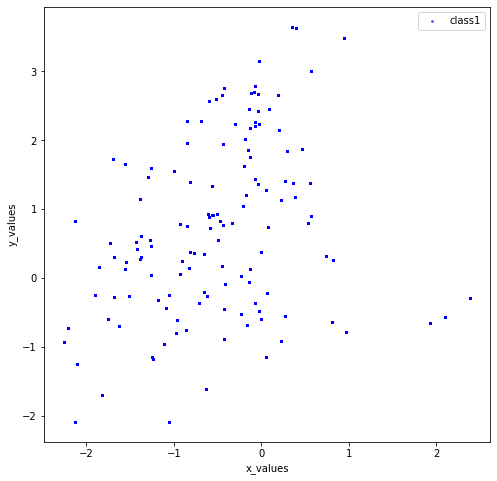

In [173]:
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d import proj3d
tocluster = pd.DataFrame(ps)
print (tocluster.shape)
print (tocluster.head())

fig = plt.figure(figsize=(8,8))
plt.plot(tocluster[0], tocluster[1], 'o', markersize=2, color='blue', alpha=0.5, label='class1')

plt.xlabel('x_values')
plt.ylabel('y_values')
plt.legend()
plt.show()

In [174]:
clusterer = KMeans(n_clusters=4,random_state=42).fit(tfidf_w2v_vectors)
centers = clusterer.cluster_centers_
c_preds_w2v = clusterer.predict(tfidf_w2v_vectors)
print(centers)

[[-3.93186856e-01  4.88189846e-01 -3.78855364e-01 -2.64631220e-02
  -4.42509067e-01  1.92026760e-01  1.10446002e+00  2.05798738e-01
   4.44742077e-01 -2.07337910e-01 -4.40911697e-01 -5.66962360e-02
   1.50440046e-02  8.61359205e-01  2.16127109e-01  2.83233749e-01
   5.81949960e-02 -4.18225186e-01  9.51527551e-02  1.73421704e-01
  -2.54336406e-01  5.73282980e-01 -1.06730750e-01 -5.25840342e-02
  -3.91325241e-01  1.16610791e+00 -6.93515691e-02 -3.62306333e-01
  -5.61238413e-01  1.71105610e-01  3.59506251e-01  7.51882886e-01
  -3.14231880e-01 -7.47908807e-01 -1.38878568e-01  7.81793483e-01
   7.01513525e-01  6.04088706e-01 -2.38915936e-01 -9.70172644e-01
   6.63165665e-01 -1.31784541e+00 -5.84660061e-01 -1.07566897e+00
   5.50949630e-01  3.09059694e-01 -6.50813478e-01 -1.96405464e-01
  -1.87846388e-02 -8.61145252e-01 -3.92821095e-01  4.48598554e-02
  -3.85719140e-01  7.34091702e-01 -1.06728385e+00 -3.19085760e-01
  -6.72595744e-01  3.29288879e-01  3.55328842e-01 -1.48779672e-01
   6.55828

In [175]:
train['cluster_aisle']=c_preds_w2v
clust_prod=train[['user_id','aisle','cluster_aisle']].copy()
clust_prod.head()

,user_id,aisle,cluster_aisle
32434489,1,cream,0
32434490,1,soft drinks,1
32434491,1,soft drinks,1
32434492,1,milk,0
32434493,1,yogurt,0


In [121]:
cl=clust_prod.groupby(['cluster_aisle','aisle']).agg({'aisle':'count'})
cl.columns=['count']
cl.reset_index(inplace=True)
cl=cl.merge(df4,on='aisle',how='inner')
cl.head()

,cluster_aisle,aisle,count,aisle_id
0,0,butter,10575,36
1,0,cream,12356,53
2,0,frozen juice,294,113
3,0,milk,32644,84
4,0,pasta sauce,9736,9


In [118]:
cl[cl['cluster']==0]['count'].shape

(8,)

<BarContainer object of 7 artists>

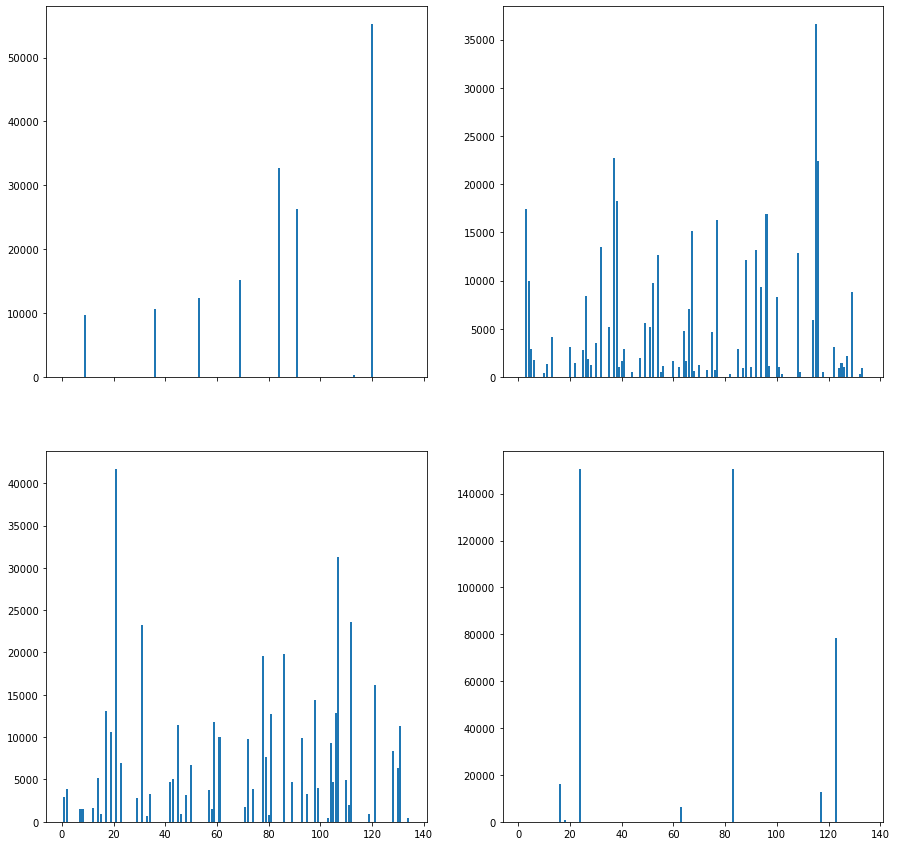

In [122]:
f,arr = plt.subplots(2,2,sharex=True,figsize=(15,15))
arr[0,0].bar(cl[cl['cluster_aisle']==0]['aisle_id'],cl[cl['cluster_aisle']==0]['count'])
arr[0,1].bar(cl[cl['cluster_aisle']==1]['aisle_id'],cl[cl['cluster_aisle']==1]['count'])
arr[1,0].bar(cl[cl['cluster_aisle']==2]['aisle_id'],cl[cl['cluster_aisle']==2]['count'])
arr[1,1].bar(cl[cl['cluster_aisle']==3]['aisle_id'],cl[cl['cluster_aisle']==3]['count'])

In [123]:
cl[cl['cluster_aisle']==0].sort_values(by='count',ascending=False)['aisle'][0:10]

7                 yogurt
3                   milk
6        soy lactosefree
5    soup broth bouillon
1                  cream
0                 butter
4            pasta sauce
2           frozen juice
Name: aisle, dtype: object

In [124]:
cl[cl['cluster_aisle']==1].sort_values(by='count',ascending=False)['aisle'][0:10]

73    water seltzer sparkling water
39                    ice cream ice
37                   frozen produce
36                     frozen meals
26              energy granola bars
45                       lunch meat
66                      soft drinks
33             fresh dips tapenades
55                 packaged produce
12                baby food formula
Name: aisle, dtype: object

In [125]:
cl[cl['cluster_aisle']==2].sort_values(by='count',ascending=False)['aisle'][0:10]

112           packaged cheese
87             chips pretzels
77                      bread
119              refrigerated
95                       eggs
90                   crackers
86                     cereal
108             juice nectars
76         baking ingredients
106    hot dogs bacon sausage
Name: aisle, dtype: object

In [126]:
cl[cl['cluster_aisle']==3].sort_values(by='count',ascending=False)['aisle'][0:10]

130                fresh vegetables
128                    fresh fruits
133      packaged vegetables fruits
129                     fresh herbs
132          nuts seeds dried fruit
131         grains rice dried goods
127    bulk dried fruits vegetables
Name: aisle, dtype: object

# How often do people re buy

In [ ]:
df=pd.read_csv('features.csv')
df.columns

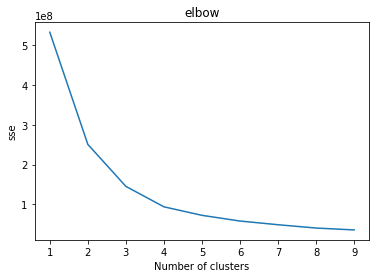

In [128]:
list1=[]
for i in range(1,10):
    clusterer = KMeans(n_clusters=i,random_state=42,init ='k-means++', max_iter=300,  n_init=10).fit(df[['user_mean_days_since_prior_orders','max_order_tot']])
    list1.append(clusterer.inertia_)
plt.plot(range(1,10),list1)
plt.title('elbow')
plt.xlabel('Number of clusters')
plt.ylabel('sse')
plt.show()

#Priors

In [28]:
clusterer =KMeans(n_clusters=5,random_state=42,init ='k-means++', max_iter=300,  n_init=10).fit(df[['user_mean_days_since_prior_orders','max_order_tot']])
centers = clusterer.cluster_centers_
c_preds = clusterer.predict(df[['user_mean_days_since_prior_orders','max_order_tot']])
df['cluster']=c_preds

print(centers)

[[ 14.42518682  41.73238506]
 [ 54.23168208   7.82067966]
 [101.30459533   4.13321946]
 [  8.16433913  81.09916316]
 [ 26.66442503  17.34447377]]


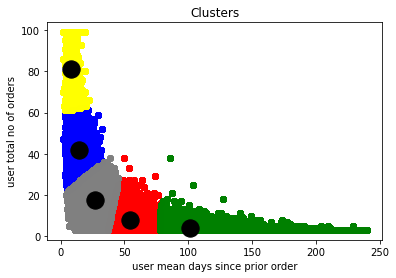

In [29]:
plt.scatter(df[df['cluster']==0]['user_mean_days_since_prior_orders'],df[df['cluster']==0]['max_order_tot'],color='blue', alpha=0.5, label='class0')
plt.scatter(df[df['cluster']==1]['user_mean_days_since_prior_orders'],df[df['cluster']==1]['max_order_tot'],color='red', alpha=0.5, label='class1')
plt.scatter(df[df['cluster']==2]['user_mean_days_since_prior_orders'],df[df['cluster']==2]['max_order_tot'],color='green', alpha=0.5, label='class2')
plt.scatter(df[df['cluster']==3]['user_mean_days_since_prior_orders'],df[df['cluster']==3]['max_order_tot'],color='yellow', alpha=0.5, label='class3')
plt.scatter(df[df['cluster']==4]['user_mean_days_since_prior_orders'],df[df['cluster']==4]['max_order_tot'],color='grey', alpha=0.5, label='class3')
plt.scatter(centers[:, 0], centers[:, 1], s=300, c='black', label = 'Centroids')
plt.title('Clusters')
plt.xlabel('user mean days since prior order')
plt.ylabel('user total no of orders')
plt.show()

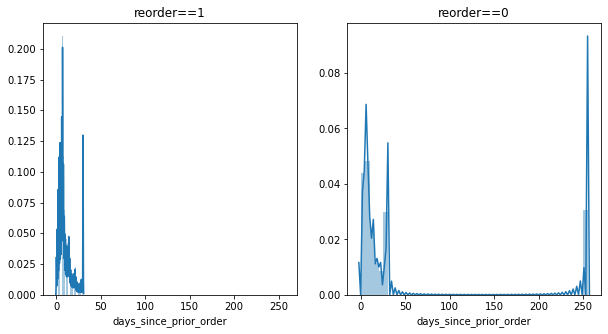

In [16]:
f,arr = plt.subplots(1,2,sharex=True,figsize=(10,5))
arr[0].set_title('reorder==1')
arr[1].set_title('reorder==0')
sns.distplot(prior['days_since_prior_order'].where(prior['reordered']==1).dropna(),ax=arr[0])
sns.distplot(prior['days_since_prior_order'].where(prior['reordered']==0).dropna(),ax=arr[1])

In [12]:
prior[prior['days_since_prior_order']>30].reordered.value_counts()

0    2078068
Name: reordered, dtype: int64

In [17]:
features=pd.read_csv('features.csv')
features.pop('Unnamed: 0')
print(features.columns)
print(features.info())
features.head()

Index(['user_id', 'product_id', 'order_count', 'order_first', 'order_last',
       'avg_cart_pos', 'prod_tot_cnts', 'prod_reorder_cnts', 'buy_1time',
       'buy_2time', 'prod_reorder_prob', 'prod_reorder_ratio',
       'prod_reorder_times', 'max_order_tot',
       'user_mean_days_since_prior_orders', 'user_mean_order_dow',
       'user_mean_order_hour_of_day', 'user_total_prod', 'user_unique_product',
       'average_basket_size', 'count', 'reorder_ratio', 'up_order_rate',
       '_up_order_since_last_order', '_up_order_rate_since_first_order'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13307953 entries, 0 to 13307952
Data columns (total 25 columns):
 #   Column                             Dtype  
---  ------                             -----  
 0   user_id                            int64  
 1   product_id                         int64  
 2   order_count                        int64  
 3   order_first                        int64  
 4   order_last       

,user_id,product_id,order_count,order_first,order_last,avg_cart_pos,prod_tot_cnts,prod_reorder_cnts,buy_1time,buy_2time,...,user_mean_order_dow,user_mean_order_hour_of_day,user_total_prod,user_unique_product,average_basket_size,count,reorder_ratio,up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order
0,1,196,10,1,10,1.400000,35791,27791.0,8000,4660,...,2.644068,10.542373,59,18,5.9,41,4.1,1.0,0,1.000000
1,1,10258,9,2,10,3.333333,1946,1389.0,557,308,...,2.644068,10.542373,59,18,5.9,41,4.1,0.9,0,1.000000
2,1,10326,1,5,5,5.000000,5526,3603.0,1923,1003,...,2.644068,10.542373,59,18,5.9,41,4.1,0.1,5,0.166667
3,1,12427,10,1,10,3.300000,6476,4797.0,1679,889,...,2.644068,10.542373,59,18,5.9,41,4.1,1.0,0,1.000000
4,1,13032,3,2,10,6.333333,3751,2465.0,1286,617,...,2.644068,10.542373,59,18,5.9,41,4.1,0.3,0,0.333333


# order streak feature

In [238]:
def apply_parallel(df_groups, _func):                              #https://www.kaggle.com/mmueller/order-streaks-feature
    nthreads = multiprocessing.cpu_count() >> 1
    print("nthreads: {}".format(nthreads))

    res = Parallel(n_jobs=nthreads)(delayed(_func)(grp.copy()) for _, grp in df_groups)
    return pd.concat(res)


def add_order_streak(df):
    tmp = df.copy()
    tmp.user_id = 1                                                     # this is done so that wherever there is 1, it means user has ordered that product in that order

    UP = tmp.pivot(index="product_id", columns='order_number').fillna(-1)       
    UP.columns = UP.columns.droplevel(0)

    x = np.abs(UP.diff(axis=1).fillna(2)).values[:, ::-1]                  # subtract current column from previous column ,fillna with 2
    df.set_index("product_id", inplace=True)
    df['order_streak'] = np.multiply(np.argmax(x, axis=1) + 1, UP.iloc[:, -1])      
    df.reset_index(drop=False, inplace=True)
    return df






orders = df1.groupby(['user_id']).tail(5 + 1)                 #take only last 5 orders
prior = orders.merge(prior, how='inner', on="order_id")
prior = prior[['user_id', 'product_id', 'order_number']]
print("prior: {}".format(prior.shape))
groups = prior.groupby('user_id')
df = apply_parallel(user_groups, add_order_streak)
df = df.drop("order_number", axis=1).drop_duplicates().reset_index(drop=True)
df = df[['user_id', 'product_id', 'order_streak']]
df.to_csv("order_streaks.csv", index=False)
print("order_streaks.csv has been written")

order_streaks.csv has been written


In [240]:
streaks=pd.read_csv("order_streaks.csv").head()

In [8]:
dl_features=prior
y=prior.reordered

In [9]:
tokenizer = Tokenizer(num_words=5000, oov_token=oov_token,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(dl_features['department'])

# Get our training data word index
word_index_d = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences_d = tokenizer.texts_to_sequences(dl_features['department'])
# Get max training sequence length


# Pad the training sequences
train_padded_d = pad_sequences(train_sequences_d, maxlen=16)
tokenizer = Tokenizer(num_words=5000, oov_token=oov_token,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(dl_features['aisle'])

# Get our training data word index
word_index_a = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences_a = tokenizer.texts_to_sequences(dl_features['aisle'])
# Get max training sequence length


# Pad the training sequences
train_padded_a = pad_sequences(train_sequences_a, maxlen=28)
tokenizer = Tokenizer(num_words=5000, oov_token=oov_token,filters='!"#$%&()*+,-./:;<=>?@[\\]^`{|}~\t\n')
tokenizer.fit_on_texts(dl_features['product_name'])

# Get our training data word index
word_index_p = tokenizer.word_index

# Encode training data sentences into sequences
train_sequences_p = tokenizer.texts_to_sequences(dl_features['product_name'])
# Get max training sequence length


# Pad the training sequences
train_padded_p = pad_sequences(train_sequences_p, maxlen=60)

In [10]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
atc=dl_features['add_to_cart_order'].values.reshape(1,-1)
normalizer.fit(atc)
atc=normalizer.transform(atc).reshape(-1,1)

on=dl_features['order_number'].values.reshape(1,-1)
normalizer.fit(on)
on=normalizer.transform(on).reshape(-1,1)

od=dl_features['order_dow'].values.reshape(1,-1)
normalizer.fit(od)
od=normalizer.transform(od).reshape(-1,1)

oh=dl_features['order_hour_of_day'].values.reshape(1,-1)
normalizer.fit(oh)
oh=normalizer.transform(oh).reshape(-1,1)

ds=dl_features['days_since_prior_order'].values.reshape(1,-1)
normalizer.fit(ds)
ds=normalizer.transform(oh).reshape(-1,1)


nu= np.hstack((atc,on,od,oh,ds))
nu.shape

(32434489, 5)

In [13]:
from numpy.random import seed
seed(1)

tf.keras.backend.clear_session()


department_in=Input(shape=(16,),name="dp")
department=Embedding(len(word_index_d)+1,8,input_length=16)(department_in)
department=LSTM(10)(department)
department=Dropout(.2)(department)
department=Flatten()(department)


aisle_in=Input(shape=(28,),name="aisle")
aisle=Embedding(len(word_index_a)+1,10,input_length=28)(aisle_in)
aisle=LSTM(10)(aisle)
aisle=Dropout(.2)(aisle)
aisle=Flatten()(aisle)


product_name_in=Input(shape=(60,),name="pn")
product_name=Embedding(len(word_index_p)+1 ,10,input_length=60)(product_name_in)
product_name=LSTM(10)(product_name)

product_name=Flatten()(product_name)


numerical_in=Input(shape=(5,),name="numerical")
numerical=Dense(units=30,activation='relu',kernel_regularizer=l2(0.01),kernel_initializer=tf.keras.initializers.HeNormal(seed=31))(numerical_in)


join= Concatenate(axis=-1)([department,aisle,product_name,numerical])

fc=Dense(units=128,activation='relu',kernel_regularizer=l2(0.01),kernel_initializer=tf.keras.initializers.HeNormal(seed=30))(join)
bn=BatchNormalization()(fc)


fc2=Dense(units=128,activation='relu',kernel_regularizer=l2(0.01),kernel_initializer=tf.keras.initializers.HeNormal(seed=23))(bn)
bn2=BatchNormalization()(fc2)


fc=Dense(units=128,activation='relu',kernel_regularizer=l2(0.01),kernel_initializer=tf.keras.initializers.HeNormal(seed=30))(bn2)
bn=BatchNormalization()(fc)

fc=Dense(units=10,activation='relu',kernel_regularizer=l2(0.01),kernel_initializer=tf.keras.initializers.HeNormal(seed=30))(bn)
bn=BatchNormalization()(fc)


drop=Dropout(.2)(bn)
out=Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.glorot_normal(seed=33))(drop)

model = Model(inputs=[department_in,aisle_in,product_name_in,numerical_in],outputs=out)


In [15]:
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)




checkpoint = ModelCheckpoint("model_2.h5",
                             monitor="loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'loss', 
                            mode="min",
                            min_delta = 0, 
                            patience = 2,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.2, patience = 1, verbose = 1, min_delta = 0.0001)




from sklearn.metrics import f1_score

def f1(y_true, y_pred):
    y_pred=y_pred>.21
    return f1_score(y_true, y_pred,average='micro')

def f1_(y_true, y_pred):
    return tf.py_function(f1, (y_true, y_pred), tf.double)



model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),loss='categorical_crossentropy',metrics=[f1_,'accuracy'])

In [14]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
dp (InputLayer)                 [(None, 16)]         0                                            
__________________________________________________________________________________________________
aisle (InputLayer)              [(None, 28)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 16, 8)        224         dp[0][0]                         
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 28, 10)       2060        aisle[0][0]                      
______________________________________________________________________________________________

In [22]:

gc.collect()

1073

In [ ]:
model.fit({'dp':train_padded_d,'aisle': train_padded_a,'pn':train_padded_p,'numerical':nu},y,epochs=10,batch_size=4048 ,steps_per_epoch=1000,callbacks=[tensorboard_callback,checkpoint])

In [ ]:
model=tf.keras.models.load_model('model_prior.h5')

In [ ]:
extract = Model(model.inputs, model.layers[-4].output)
features = extract.predict({'dp':train_padded_d,'aisle': train_padded_a,'pn':train_padded_p,'numerical':nu})

In [ ]:
features_df = pd.DataFrame(data=features,columns=[i for i in range(10)])
features_df.head()

In [ ]:
train_features=pd.concat([train[['product_id','user_id','reordered','cluster_aisle','cluster_frequency_buy']],features_df],axis=1)
train_features.shape
train_features.head()

In [ ]:
train_features=train_features.drop([7,8,9],axis=1)                          #drop the last 3 dimensions as they are 0 
features_train=pd.merge(train_features,up,on=['user_id','product_id'],how='inner')
features_train.head()

# HERE

In [ ]:
features=pd.read_csv('features.csv')
features=features.drop('Unnamed: 0',axis=1)
streaks=pd.read_csv('order_streaks.csv')
features=features.merge(streaks,how='left',on=['user_id','product_id'])
features=features.fillna(0)


In [ ]:
f,na_list=reduce_mem_usage(features)

In [ ]:
del features
gc.collect()

In [8]:
f = f.merge(df1.where((df1['eval_set']=='test') | (df1['eval_set']=='train')).dropna()[['order_id', 'user_id','eval_set']], how='left', on='user_id')


In [11]:
train=f[f['eval_set']=='train']

In [12]:
train=train.merge(df[['order_id','product_id','reordered']],on=['order_id','product_id'],how='left')
train.head()

,user_id,product_id,order_count,order_first,order_last,avg_cart_pos,prod_tot_cnts,prod_reorder_cnts,buy_1time,buy_2time,...,average_basket_size,count,reorder_ratio,up_order_rate,_up_order_since_last_order,_up_order_rate_since_first_order,cluster,order_id,eval_set,reordered
0,1,196,10,1,10,1.400000,35791,27791,8000,4660,...,5.9,41,4.1,1.0,0,1.000000,1,1187899.0,train,1.0
1,1,10258,9,2,10,3.333333,1946,1389,557,308,...,5.9,41,4.1,0.9,0,1.000000,1,1187899.0,train,1.0
2,1,10326,1,5,5,5.000000,5526,3603,1923,1003,...,5.9,41,4.1,0.1,5,0.166667,1,1187899.0,train,NaN
3,1,12427,10,1,10,3.300000,6476,4797,1679,889,...,5.9,41,4.1,1.0,0,1.000000,1,1187899.0,train,NaN
4,1,13032,3,2,10,6.333333,3751,2465,1286,617,...,5.9,41,4.1,0.3,0,0.333333,1,1187899.0,train,1.0


In [13]:
train.isnull().sum()

user_id                                    0
product_id                                 0
order_count                                0
order_first                                0
order_last                                 0
avg_cart_pos                               0
prod_tot_cnts                              0
prod_reorder_cnts                          0
buy_1time                                  0
buy_2time                                  0
prod_reorder_prob                          0
prod_reorder_ratio                         0
prod_reorder_times                         0
max_order_tot                              0
user_mean_days_since_prior_orders          0
user_mean_order_dow                        0
user_mean_order_hour_of_day                0
user_total_prod                            0
user_unique_product                        0
average_basket_size                        0
count                                      0
reorder_ratio                              0
up_order_r

In [52]:
train=train.fillna(0)

In [14]:
# train.pop('Unnamed: 0')
train.shape

(8474661, 29)

In [15]:
streaks=pd.read_csv('order_streaks.csv')
features_train=train.merge(streaks,how='left',on=['user_id','product_id'])
features_train=features_train.fillna(0)
features_train.shape

(8474661, 30)

In [57]:
features_train.to_csv('with_streaks.csv')

In [103]:
features_train=pd.read_csv('with_streaks.csv')
features_train,na_list=reduce_mem_usage(features_train)
features_train=features_train.fillna(0)
features_train.pop('Unnamed: 0')
features_train.columns

Memory usage of properties dataframe is : 2004.3526229858398  MB
******************************
Column:  Unnamed: 0
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  product_id
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  order_count
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  order_first
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  order_last
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  avg_cart_pos
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  prod_tot_cnts
dtype before

Index(['user_id', 'product_id', 'order_count', 'order_first', 'order_last',
       'avg_cart_pos', 'prod_tot_cnts', 'prod_reorder_cnts', 'buy_1time',
       'buy_2time', 'prod_reorder_prob', 'prod_reorder_ratio',
       'prod_reorder_times', 'max_order_tot',
       'user_mean_days_since_prior_orders', 'user_mean_order_dow',
       'user_mean_order_hour_of_day', 'user_total_prod', 'user_unique_product',
       'average_basket_size', 'count', 'reorder_ratio', 'up_order_rate',
       '_up_order_since_last_order', '_up_order_rate_since_first_order',
       'cluster', 'order_id', 'eval_set', 'reordered', 'order_streak'],
      dtype='object')

In [104]:
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
#         if feature_name in range(10):
#             continue
        mean = df[feature_name].mean()
        std = df[feature_name].std()
        max = df[feature_name].max()
        min = df[feature_name].min()
#         result[feature_name] = (df[feature_name] - min) / max-min
        result[feature_name] = (df[feature_name] - mean) / std
    return result


In [5]:
features_train.columns

Index(['user_id', 'product_id', 'order_count', 'order_first', 'order_last',
       'avg_cart_pos', 'prod_tot_cnts', 'prod_reorder_cnts', 'buy_1time',
       'buy_2time', 'prod_reorder_prob', 'prod_reorder_ratio',
       'prod_reorder_times', 'max_order_tot',
       'user_mean_days_since_prior_orders', 'user_mean_order_dow',
       'user_mean_order_hour_of_day', 'user_total_prod', 'user_unique_product',
       'average_basket_size', 'count', 'reorder_ratio', 'up_order_rate',
       '_up_order_since_last_order', '_up_order_rate_since_first_order',
       'cluster', 'order_id', 'eval_set', 'reordered', 'order_streak'],
      dtype='object')

In [39]:
from sklearn.model_selection import train_test_split
X, X_test, y_train, y_test = train_test_split(normalize(features_train.drop(['user_id','product_id','eval_set','order_id','reordered'],axis=1)), features_train.reordered, test_size=0.8,stratify=features_train.reordered)


# Deep learning model on train_features

In [8]:
from numpy.random import seed
seed(1)

tf.keras.backend.clear_session()




_in=Input(shape=(25,),name="numerical")
fc=Dense(units=64,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=31))(_in)


fc1=Dense(units=128,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=30))(fc)
bn=BatchNormalization()(fc1)


fc2=Dense(units=256,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=23))(bn)
bn=BatchNormalization()(fc2)
drop2=Dropout(.2)(bn)

fc3=Dense(units=128,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=30))(drop2)
bn=BatchNormalization()(fc3)
drop=Dropout(.2)(fc3)
fc4=Dense(units=74,activation='relu',kernel_initializer=tf.keras.initializers.he_normal(seed=30))(drop)
bn=BatchNormalization()(fc4)


out=Dense(units=1,activation='sigmoid',kernel_initializer=tf.keras.initializers.he_normal(seed=33))(bn)

model = Model(inputs=_in,outputs=out)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
numerical (InputLayer)       [(None, 25)]              0         
_________________________________________________________________
dense (Dense)                (None, 64)                1664      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0     

In [9]:
log_dir="logs\\fit\\" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1)




checkpoint = ModelCheckpoint("model_test.h5",
                             monitor="loss",
                             mode="min",
                             save_best_only = True,
                             verbose=1)

earlystop = EarlyStopping(monitor = 'loss', 
                            mode="min",
                            min_delta = .00001, 
                            patience = 2,
                            verbose = 1,
                            restore_best_weights = True)

reduce_lr = ReduceLROnPlateau(monitor = 'loss', factor = 0.8, patience = 4, verbose = 1, min_delta = 0.0001)



from sklearn.metrics import f1_score

def f1(y_true, y_pred):
    y_pred=y_pred>.21                                                     # global threshold

    return f1_score(y_true, y_pred)

def f1_(y_true, y_pred):
    return tf.py_function(f1, (y_true, y_pred), tf.double)

def f12(y_true, y_pred):
    y_pred=y_pred>.30                                                     # global threshold

    return f1_score(y_true, y_pred)

def f1_1(y_true, y_pred):
    return tf.py_function(f12, (y_true, y_pred), tf.double)

def f13(y_true, y_pred):
    y_pred=y_pred>.1                                                     # global threshold

    return f1_score(y_true, y_pred)

def f1_2(y_true, y_pred):
    return tf.py_function(f13, (y_true, y_pred), tf.double)

def f14(y_true, y_pred):
    y_pred=y_pred>.4                                                     # global threshold

    return f1_score(y_true, y_pred)

def f1_3(y_true, y_pred):
    return tf.py_function(f14, (y_true, y_pred), tf.double)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='binary_crossentropy',metrics=[f1_,f1_1,f1_2,f1_3,'accuracy'])

In [10]:
x=normalize(features_train.drop(['user_id','product_id','eval_set','order_id','reordered'],axis=1))

In [273]:
history=model.fit(x,features_train.reordered,epochs=100,batch_size=4048,callbacks=[tensorboard_callback,checkpoint,reduce_lr])

Epoch 1/100
2094/2094 [==============================] - 41s 18ms/step - loss: 0.3085 - f1_: 0.3766 - f1_1: 0.3663 - f1_2: 0.3179 - f1_3: 0.3247 - accuracy: 0.8899 50s - loss: 0.6407 - f1_: 0.1820 - f - ETA: 15s - loss: 0.3367 - f1_: 0.3532 - f1_1: 0.3508 - f1_2: 0.2951 - f1_ - ETA: 15s - loss: 0.3343 - f1_: 0.3551 - f1 - ETA: 9s - loss: 0.3222 - f1_: 0.3651 - f1_1: 0.3586 - f1_2: 0.3066 - f1_3: 0.323 - ETA: 7s - loss: 0.3197 - f1_: 0.3671 - f1_1: 0.3600 - f1_2: 0.3086 - f1_3: 0.3233 - accuracy: 0.886 - ETA: 7s - loss: 0.3196 - f1_: 0.3672 - f1_1: 0.3601 - f1_2: 0. - ETA: 5s - loss: 0.3159 - f1_: 0.3703 - f1_1: 0.3622 - f1_2: - ETA: 2s - loss: 0.3120 - f1_: 0.3736 - f1_1: 0.3643 - f1

Epoch 00001: loss improved from inf to 0.26365, saving model to model_test.h5
Epoch 2/100
2094/2094 [==============================] - 38s 18ms/step - loss: 0.2486 - f1_: 0.4323 - f1_1: 0.4067 - f1_2: 0.3727 - f1_3: 0.3396 - accuracy: 0.9086 10s - loss: 0.2486 - f1 - ETA: 6s - loss: 0.2486 - f1_: 0.4322 -

2094/2094 [==============================] - 34s 16ms/step - loss: 0.2466 - f1_: 0.4365 - f1_1: 0.4173 - f1_2: 0.3755 - f1_3: 0.3540 - accuracy: 0.9092 18s - loss: 0.2468 - f1_: 0.4364 - f1_1: 0.4177 - f1_2: 0.3751 - f1_3: - ETA: 6s - loss: 0.2467 - f1_: 0.4364 - f1_1: 0.4173 - f1_2: 0.3753 - f1_3: 0.3539 - ETA: 5s - loss: 0.2467 - f1_: 0.4364 - f1_1: 0.4173 - f1_2: 0.3753 - f1_3: 0.3539 - accuracy: 0.909 - ETA: 5s - loss: 0.2467 - f1_: 0.4364 - f1_1: 0.4173 - f1_2: 0.3753 - f1_3 - ETA: 3s - loss: 0.2467 - f1_: 0.4364 - f1_1: 0

Epoch 00032: loss did not improve from 0.24640

Epoch 00032: ReduceLROnPlateau reducing learning rate to 0.0006400000303983689.
Epoch 33/100
2094/2094 [==============================] - 34s 16ms/step - loss: 0.2459 - f1_: 0.4366 - f1_1: 0.4172 - f1_2: 0.3758 - f1_3: 0.3548 - accuracy: 0.9095 22s - loss: 0.2455 - f1_: 0.4359 - f1_1: 0.4161 - f1_2: 0.3751 - f1_3: 0.3534 -  - ETA: 21s - loss: 0.2455 - f1_: 0.4359 - f1_1: 0.4162 - f1_2: 0.3751 - f1_3: 0.3535 - accu

2094/2094 [==============================] - 34s 16ms/step - loss: 0.2456 - f1_: 0.4380 - f1_1: 0.4189 - f1_2: 0.3789 - f1_3: 0.3575 - accuracy: 0.9095 28s - loss: 0.2455 - f1_: 0.43 - ETA: 22s - loss: 0.2456 - f1_: 0.4368 - ETA: 20s - loss: 0.2456 - f - ETA: 14s - loss: 0.2457 - f1_: 0.4375 - f1_1: 0.4183 - f1_2: 0.3787 - f1_3: 0.3566 -  - ETA: 14s - loss: 0.2457 - f1_: 0.4376 - f1_1: 0.4183 - f1_2: 0.3787 - - ETA: 13s - loss: 0.24 - ETA: 11s - loss: 0.2457 - f1_: 0.4377 - f1_1: 0.4185 - f1_2: 0.3788 - f1_3: 0.3569 -  - ETA: 10s - loss - ETA: 5s - loss: 0.2457 - f1_: 0.4379 - f1_1: 0.4187 - f1_2: 0.3789 - f1_3: - ETA: 4s - loss: 0.2456 - f1_: 0.4380 - f1_1: 0.4188 - f1_2: 0.3789 - f1_3: 0.357 - ETA: 2s - loss: 0.2456 - f1_: 0.4380 - f1_1: 0.4188 

Epoch 00062: loss improved from 0.24560 to 0.24560, saving model to model_test.h5

Epoch 00062: ReduceLROnPlateau reducing learning rate to 0.00016777217388153076.
Epoch 63/100
2094/2094 [==============================] - 34s 16ms/step - los

2094/2094 [==============================] - 34s 16ms/step - loss: 0.2452 - f1_: 0.4394 - f1_1: 0.4205 - f1_2: 0.3805 - f1_3: 0.3599 - accuracy: 0.9096 11s - loss: 0.2451 - f1_: 0.4396 - ETA: 9s - loss: 0.2452 - f1_: 0.4396 - f1_1: 0.4206 - f1_2: 0.3806 - f1_3: 0.3601 - - ETA: 8s - loss: 0.2452 - f1_: 0.4396 - f1_1: 0.4206 - f1_2: 0.3806 - f1_3 - ETA: 7s - loss: 0.2452 - f1_: 0.4395 - f1_1: 0.4206 - f1_2:  - ETA: 4s - loss: 0.2452 - f1_: 0.4395 - f1_1: 0.4206 - f1_2: 0.3806 - f1_3: - ETA: 3s - loss: 0.2452 - f1_: 0.4395 - f1_1: 0.4206 - f1_2 - ETA: 0s - loss: 0.2452 - f1_: 0.4394 - f1_1: 0.4206 - f1_2: 0.3805 - f1_3: 0.3599 - accuracy:

Epoch 00079: loss improved from 0.24539 to 0.24536, saving model to model_test.h5
Epoch 80/100
2094/2094 [==============================] - 34s 16ms/step - loss: 0.2449 - f1_: 0.4391 - f1_1: 0.4204 - f1_2: 0.3797 - f1_3: 0.3595 - accuracy: 0.9097 25s - loss: 0.2442 - f1_: 0.4383 - f1_1: 0.4201 - f1_2: 0. - ETA: 24s - lo - ETA: 21s - loss: 0.2444 - f1_: 

In [11]:
history=model.fit(x,features_train.reordered,epochs=2,batch_size=4048,callbacks=[tensorboard_callback,checkpoint,reduce_lr])

Epoch 1/2
2094/2094 [==============================] - 37s 17ms/step - loss: 0.3083 - f1_: 0.3769 - f1_1: 0.3664 - f1_2: 0.3180 - f1_3: 0.3249 - accuracy: 0.8902 2s - loss: 0.3124 - f1_: 0.3734 - f1_1: 0.3640 - f1_2: 0.3145 - f1_3: 0.3 - ETA: 1s - loss: 0.3104 - f1_: 0.3751 - f1_1: 0.3652 - f1_2: 0.3162 - f1_3: 

Epoch 00001: loss improved from inf to 0.26356, saving model to model_test.h5
Epoch 2/2
2094/2094 [==============================] - 35s 17ms/step - loss: 0.2486 - f1_: 0.4319 - f1_1: 0.4079 - f1_2: 0.3726 - f1_3: 0.3411 - accuracy: 0.9086 12s - loss: 0.2487 - f1_: 0.4316 - f1_1: 0.4077 - f1_2: 0.3725 - f1_3: 0.3408 -  - ETA: 11s - loss: 0 - ETA: 7s - loss: 0.2487 - f1_: 0.4317 - f1_1: 0.4077 - f1_2: 0.3725 - f1_3: 0.

Epoch 00002: loss improved from 0.26356 to 0.24841, saving model to model_test.h5


# Xg-boost

In [105]:
features_train.drop(['user_id', 'product_id','eval_set', 'order_id'], axis=1, inplace=True)
y=features_train.pop('reordered')
features_train=normalize(features_train)
X_train, X_test, y_train, y_test = train_test_split(features_train, y,test_size=0.8, random_state=2)

[0]	train-logloss:0.62582
[10]	train-logloss:0.33603
[20]	train-logloss:0.26959
[30]	train-logloss:0.25278
[40]	train-logloss:0.24847
[50]	train-logloss:0.24719
[60]	train-logloss:0.24665
[70]	train-logloss:0.24633
[80]	train-logloss:0.24606
[90]	train-logloss:0.24583
[100]	train-logloss:0.24561
[110]	train-logloss:0.24542
[120]	train-logloss:0.24523
[130]	train-logloss:0.24508
[140]	train-logloss:0.24489
[150]	train-logloss:0.24471
[160]	train-logloss:0.24456
[170]	train-logloss:0.24441
[180]	train-logloss:0.24424
[190]	train-logloss:0.24407
[199]	train-logloss:0.24394


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

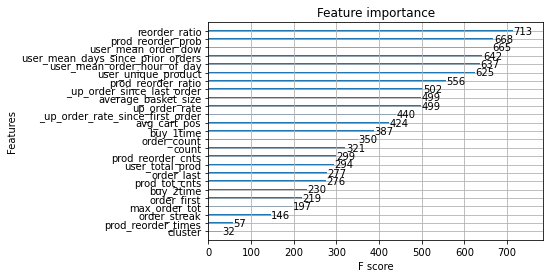

In [106]:


# X_test = f.loc[f.eval_set == "test",:]
# X_test=X_test.merge(streaks,how='left',on=['user_id','product_id'])
# X_test=X_test.fillna(0)


d_train = xgboost.DMatrix(X_train, y_train)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=200, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

In [9]:
import joblib
joblib.dump(bst, 'model.pkl')

['model.pkl']

In [51]:
def get_sub(final,string):
    final=final.merge(df1[df1['eval_set']=='test'][['user_id','order_id']],on='user_id',how='left')
    final=final.drop(['user_id'],axis=1)
    final['product_id'] = final.product_id.astype(int)
    dict2={}
    for row in final.itertuples():
        try:
            if row.reordered== 1:
                dict2[row.order_id] += ' ' + str(row.product_id)
        except:
            dict2[row.order_id] = str(row.product_id)

    for order in final['order_id']:
        if order not in dict2:
            dict2[order] = 'None'
    sub = pd.DataFrame.from_dict(dict2, orient='index')

    #Reset index
    sub.reset_index(inplace=True)
    #Set column names
    sub.columns = ['order_id', 'products']
    sub.to_csv(string+'sub.csv', index=False)
    return sub.head()

In [ ]:
model=tf.keras.models.load_model('model_test.h5')
# model_dense=tf.keras.models.load_model('model_dense.h5')

In [23]:
test=f[f['eval_set']=='test']
streaks=pd.read_csv('order_streaks.csv')
features=test.merge(streaks,on=['user_id', 'product_id'],how='left')

In [25]:
features.to_csv('with_streaks_test.csv')

In [47]:
features_test=pd.read_csv('with_streaks_test.csv')
features_test.pop('Unnamed: 0')
features_test,g=reduce_mem_usage(features_test)

Memory usage of properties dataframe is : 1069.3777770996094  MB
******************************
Column:  user_id
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  product_id
dtype before:  int64
dtype after:  uint16
******************************
******************************
Column:  order_count
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  order_first
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  order_last
dtype before:  int64
dtype after:  uint8
******************************
******************************
Column:  avg_cart_pos
dtype before:  float64
dtype after:  float32
******************************
******************************
Column:  prod_tot_cnts
dtype before:  int64
dtype after:  uint32
******************************
******************************
Column:  prod_reorder_cnts
dtype

# Predict dl-model

In [ ]:
model =  tf.keras.models.load_model('model_test.h5')

In [14]:
features_test.columns

Index(['user_id', 'product_id', 'order_count', 'order_first', 'order_last',
       'avg_cart_pos', 'prod_tot_cnts', 'prod_reorder_cnts', 'buy_1time',
       'buy_2time', 'prod_reorder_prob', 'prod_reorder_ratio',
       'prod_reorder_times', 'max_order_tot',
       'user_mean_days_since_prior_orders', 'user_mean_order_dow',
       'user_mean_order_hour_of_day', 'user_total_prod', 'user_unique_product',
       'average_basket_size', 'count', 'reorder_ratio', 'up_order_rate',
       '_up_order_since_last_order', '_up_order_rate_since_first_order',
       'cluster', 'order_id', 'eval_set', 'order_streak'],
      dtype='object')

In [15]:
val_predict_test = model.predict(normalize(features_test.drop(['order_id','user_id','eval_set','product_id'],axis=1)))

In [40]:
from datetime import datetime
class F1Optimizer():
    def __init__(self):                                             # https://www.kaggle.com/mmueller/f1-score-expectation-maximization-in-o-n
        pass

    @staticmethod
    def get_expectations(P, pNone=None):
        expectations = []
        P = np.sort(P)[::-1]

        n = np.array(P).shape[0]
        DP_C = np.zeros((n + 2, n + 1))
        if pNone is None:
            pNone = (1.0 - P).prod()

        DP_C[0][0] = 1.0
        for j in range(1, n):
            DP_C[0][j] = (1.0 - P[j - 1]) * DP_C[0, j - 1]

        for i in range(1, n + 1):
            DP_C[i, i] = DP_C[i - 1, i - 1] * P[i - 1]
            for j in range(i + 1, n + 1):
                DP_C[i, j] = P[j - 1] * DP_C[i - 1, j - 1] + (1.0 - P[j - 1]) * DP_C[i, j - 1]

        DP_S = np.zeros((2 * n + 1,))
        DP_SNone = np.zeros((2 * n + 1,))
        for i in range(1, 2 * n + 1):
            DP_S[i] = 1. / (1. * i)
            DP_SNone[i] = 1. / (1. * i + 1)
        for k in range(n + 1)[::-1]:
            f1 = 0
            f1None = 0
            for k1 in range(n + 1):
                f1 += 2 * k1 * DP_C[k1][k] * DP_S[k + k1]
                f1None += 2 * k1 * DP_C[k1][k] * DP_SNone[k + k1]
            for i in range(1, 2 * k - 1):
                DP_S[i] = (1 - P[k - 1]) * DP_S[i] + P[k - 1] * DP_S[i + 1]
                DP_SNone[i] = (1 - P[k - 1]) * DP_SNone[i] + P[k - 1] * DP_SNone[i + 1]
            expectations.append([f1None + 2 * pNone / (2 + k), f1])

        return np.array(expectations[::-1]).T

    @staticmethod
    def maximize_expectation(P, pNone=None):
        expectations = F1Optimizer.get_expectations(P, pNone)

        ix_max = np.unravel_index(expectations.argmax(), expectations.shape)
        max_f1 = expectations[ix_max]

        predNone = True if ix_max[0] == 0 else False
        best_k = ix_max[1]

        return best_k, predNone, max_f1

    @staticmethod
    def _F1(tp, fp, fn):
        return 2 * tp / (2 * tp + fp + fn)

    @staticmethod
    def _Fbeta(tp, fp, fn, beta=1.0):
        beta_squared = beta ** 2
        return (1.0 + beta_squared) * tp / ((1.0 + beta_squared) * tp + fp + beta_squared * fn)

def timeit(P):
    s = datetime.now()
    F1Optimizer.maximize_expectation(P)
    e = datetime.now()
    return (e-s).microseconds / 1E6





100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [2:06:15<00:00,  9.90it/s]


<Figure size 432x288 with 0 Axes>

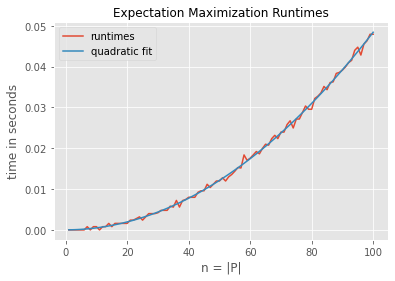

In [19]:
if __name__ == '__main__':
    dict1={}
    grps=final_dl.groupby('user_id')
    for i,grp in tqdm(grps):
        out= F1Optimizer.maximize_expectation(grp['reordered'].sort_values(ascending=False), None)
        dict1[i]=out[0]
    benchmark()

# high level idea for above script is only use top prob scores of products to maximize E{f1}

In [298]:
val=val_predict_test[:]>.21            # deep learning model f1 eval
list1=[]
for i in val_predict_test:
    if i >.21:
        
        list1.append(1)
    else:
        list1.append(0)
    


In [17]:
features_test['reordered']=val_predict_test

In [18]:
final_dl=features_test[['product_id','user_id','reordered']]
final_dl.head()

,product_id,user_id,reordered
0,196,15,0.474602
1,12427,15,0.310530
2,1747,15,0.154784
3,10441,15,0.359420
4,11266,15,0.264115


In [86]:
user_id=np.unique(final_dl['user_id'])
glob=0
for i in range(len(user_id)):
    
    df=final_dl[final_dl['user_id']==user_id[i]]
    df=df.sort_values('reordered',ascending=False)
    if dict1[user_id[i]]=='None':
        continue
    else:
        df=df.iloc[:dict1[user_id[i]]]
    temp=df
    if i==0:
        glob=temp
    else:
        glob=pd.concat([glob,temp])


In [87]:
final=glob.copy()
final['reordred']=[1 for i in final['reordered']]

In [88]:
f=final.merge(final_dl,on=['product_id','user_id'],how='right').fillna(0)
f.shape

(4833292, 5)

# Predict xg -boost 

In [108]:
d_test = xgboost.DMatrix(normalize(features_test.drop(['eval_set', 'user_id', 'order_id', 'product_id','reordered'], axis=1)))
features_test['reordered'] = (bst.predict(d_test) > 0.21).astype(int)         # deep learning model f1 eval


In [109]:
# final=features[['product_id','user_id','reordered']]
# final.head()
final_xg=features_test[['product_id','user_id','reordered']]
final_xg.head()

,product_id,user_id,reordered
0,196,15,1
1,12427,15,1
2,1747,15,0
3,10441,15,1
4,11266,15,1


100%|██████████████████████████████████████████████████████████████████████████| 75000/75000 [2:03:41<00:00, 10.11it/s]


<Figure size 432x288 with 0 Axes>

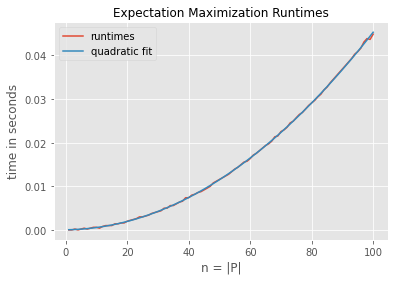

In [15]:
if __name__ == '__main__':
    dict1={}
    grps=final_xg.groupby('user_id')
    for i,grp in tqdm(grps):
        out= F1Optimizer.maximize_expectation(grp['reordered'].sort_values(ascending=False), None)
        dict1[i]=out[0]
    benchmark()

In [16]:
final_xg.head()

,product_id,user_id,reordered
0,196,15,0.531692
1,12427,15,0.322469
2,1747,15,0.147145
3,10441,15,0.409094
4,11266,15,0.260606


In [17]:
user_id=np.unique(final_xg['user_id'])
glob=0
for i in range(len(user_id)):
    
    df=final_xg[final_xg['user_id']==user_id[i]]
    df=df.sort_values('reordered',ascending=False)
    if dict1[user_id[i]]=='None' or dict1[user_id[i]]==0:
        continue   
    else:
        df=df.iloc[:dict1[user_id[i]]]
    temp=df
    if i==0:
        glob=temp
    else:
        glob=pd.concat([glob,temp])

In [18]:
final=glob.copy()
final['reordred']=[1 for i in final['reordered']]

In [19]:
f=final.merge(final_xg,on=['product_id','user_id'],how='right').fillna(0)
f.shape

(4833292, 5)

# Logistic regression

In [286]:
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

100%|███████████████████████████████████████████████████████████████████████████████████| 9/9 [28:03<00:00, 187.08s/it]


log_loss for c =  1e-05 is 0.2539478900080722
log_loss for c =  0.0001 is 0.25282746430573205
log_loss for c =  0.001 is 0.2527256662262967
log_loss for c =  0.01 is 0.2527172865497193
log_loss for c =  0.1 is 0.2527163559793193
log_loss for c =  1 is 0.25271631672933476
log_loss for c =  10 is 0.25271633287254647
log_loss for c =  100 is 0.2527163597137781
log_loss for c =  1000 is 0.2527163362866339


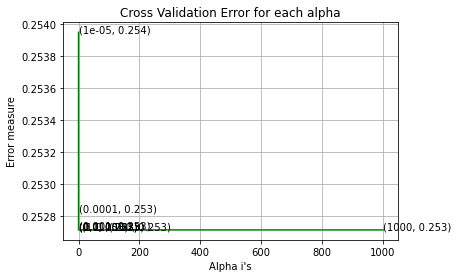

log loss for train data 0.25271631672933476
log loss for cv data 0.25343865960332296


In [85]:
alpha = [10 ** x for x in range(-5, 4)]
cv_log_error_array=[]
for i in tqdm(alpha):
    logisticR=LogisticRegression(penalty='l2',C=i,class_weight='balanced')
    logisticR.fit(X,y_train)
    sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
    sig_clf.fit(X, y_train)
    predict_y = sig_clf.predict_proba(X)
    cv_log_error_array.append(log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
    
for i in range(len(cv_log_error_array)):
    print ('log_loss for c = ',alpha[i],'is',cv_log_error_array[i])

best_alpha = np.argmin(cv_log_error_array)
    
fig, ax = plt.subplots()
ax.plot(alpha, cv_log_error_array,c='g')
for i, txt in enumerate(np.round(cv_log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],cv_log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()

logisticR=LogisticRegression(penalty='l2',C=alpha[best_alpha],class_weight='balanced')
logisticR.fit(X,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X, y_train)
pred_y=sig_clf.predict(X_test)

predict_y = sig_clf.predict_proba(X)
print ('log loss for train data',log_loss(y_train, predict_y, labels=logisticR.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print ('log loss for cv data',log_loss(y_test, predict_y, labels=logisticR.classes_, eps=1e-15))


In [287]:
logisticR=LogisticRegression(penalty='l2',C=.1,class_weight='balanced')
logisticR.fit(X,y_train)
sig_clf = CalibratedClassifierCV(logisticR, method="sigmoid")
sig_clf.fit(X, y_train)
pred_y=sig_clf.predict(X_test)

In [304]:
val=sig_clf.predict_proba(normalize(features_test.drop(['order_id','user_id','eval_set','product_id','reordered'],axis=1)))

In [305]:
list1=[]
for i in val[:,1]:
    if i>.21:
        list1.append(1)
    else:
        list1.append(0)

In [306]:
features_test['reordered'] = list1
final_log=features_test[['product_id','user_id','reordered']]
final_log.head()

,product_id,user_id,reordered
0,196,15,1
1,12427,15,1
2,1747,15,0
3,10441,15,1
4,11266,15,1


# Ensemble

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [86]:
f=features_train.drop(['user_id', 'product_id','eval_set', 'order_id','reordered'], axis=1)
f=normalize(f)
X_train, X_test, y_train, y_test = train_test_split(f, features_train.reordered,test_size=0.2, random_state=2,stratify=features_train.reordered)

In [87]:
D1, D2, y1, y2 = train_test_split(X_train,y_train,test_size=0.5, random_state=2,stratify=y_train)


In [181]:

def generating_samples(input_data, target_data):

    clmns=random_columns=random.randint(5,25)           #select the no of features 
    list_of_clmns=range(clmns)
    random_rows=random.sample(range(D1.shape[0]),k=D1.shape[0]//4)                         #random row indices
    sample =[input_data.iloc[sample][:clmns].values for sample in random_rows]
    sample=np.vstack(sample)
    target_sample=([target_data.iloc[sample] for sample in random_rows])
    full_target=np.asarray(target_sample).reshape(-1,1)
      
        
    return sample,full_target,random_rows,list_of_clmns

In [182]:
list_input_data =[]
list_output_data =[]
list_selected_row= []
list_selected_columns=[]

list_of_trees=[]
for i in range(15):
    a,b,c,d = generating_samples(D1, y1)
    list_input_data.append(a)
    list_output_data.append(b)
    list_selected_row.append(c)
    list_selected_columns.append(d)
    

In [183]:
list_of_trees=[]
for i in range (15):
    tree=DecisionTreeClassifier(max_depth=10)
    tree.fit(list_input_data[i],list_output_data[i])
    list_of_trees.append(tree)

In [184]:
pred=[]
for y,z in zip(list_selected_columns,list_of_trees):
    sample =D2.iloc[:,:y[-1]+1]
    pred.append(z.predict(sample))
   
    
dict1={}
for i in range(len(pred)):
    dict1['f'+str(i)]=pred[i]
ensemble=pd.DataFrame(dict1)
ensemble.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


[0]	train-logloss:0.62646
[10]	train-logloss:0.35174
[20]	train-logloss:0.29844
[30]	train-logloss:0.28639
[40]	train-logloss:0.28604
[50]	train-logloss:0.28440
[60]	train-logloss:0.28548
[70]	train-logloss:0.28505
[79]	train-logloss:0.28508


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

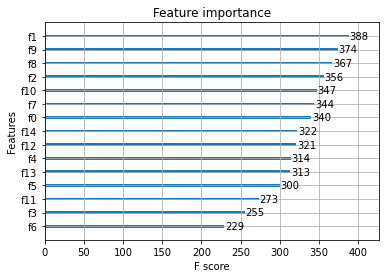

In [185]:
d_train = xgboost.DMatrix(ensemble,y2)
xgb_params = {
    "objective"         : "reg:logistic"
    ,"eval_metric"      : "logloss"
    ,"eta"              : 0.1
    ,"max_depth"        : 6
    ,"min_child_weight" :10
    ,"gamma"            :0.70
    ,"subsample"        :0.76
    ,"colsample_bytree" :0.95
    ,"alpha"            :2e-05
    ,"lambda"           :10
}

watchlist= [(d_train, "train")]
bst = xgboost.train(params=xgb_params, dtrain=d_train, num_boost_round=80, evals=watchlist, verbose_eval=10)
xgboost.plot_importance(bst)

# Test

In [186]:
pred=[]
for y,z in zip(list_selected_columns,list_of_trees):
    sample =X_test.iloc[:,:y[-1]+1]
    pred.append(z.predict(sample))
dict1={}
for i in range(len(pred)):
    dict1['f'+str(i)]=pred[i]
ensemble_test=pd.DataFrame(dict1)
ensemble_test.head()

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [187]:
d_test= xgboost.DMatrix(ensemble_test)
y_hat=(bst.predict(d_test)>.21).astype(int)

In [188]:
ensemble_test['y']=y_test
ensemble_test['y_hat']=y_hat
f1_score(y_test, y_hat, average='micro')

0.8968767497004306

In [189]:
# features_test=normalize(features_test)
f=features_test.drop(['order_id','user_id','eval_set','product_id'],axis=1)
pred=[]
for y,z in tqdm(zip(list_selected_columns,list_of_trees)):
    sample =f.iloc[:,:y[-1]+1]
    pred.append(z.predict(sample))
dict1={}
for i in range(len(pred)):
  
    dict1['f'+str(i)]=pred[i]
ensemble_test=pd.DataFrame(dict1)
ensemble_test.head()

15it [00:11,  1.28it/s]


,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14
0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
4,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


In [193]:
d_test= xgboost.DMatrix(ensemble_test)
y_hat=(bst.predict(d_test)>.21).astype(int)
features_test['reordered'] = y_hat
final_ensemble=features_test[['product_id','user_id','reordered']]
final_ensemble.head()

,product_id,user_id,reordered
0,196,15,1
1,12427,15,1
2,1747,15,1
3,10441,15,1
4,11266,15,1


# Submission screenshots

In [111]:
from IPython.display import Image as i

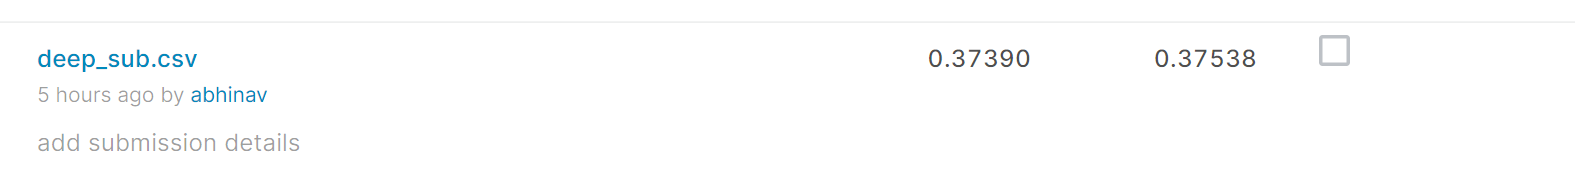

In [92]:
g=get_sub(f,'deep_')                                 #dl
i(filename="C:/Users/Abhi/Desktop/1.png")

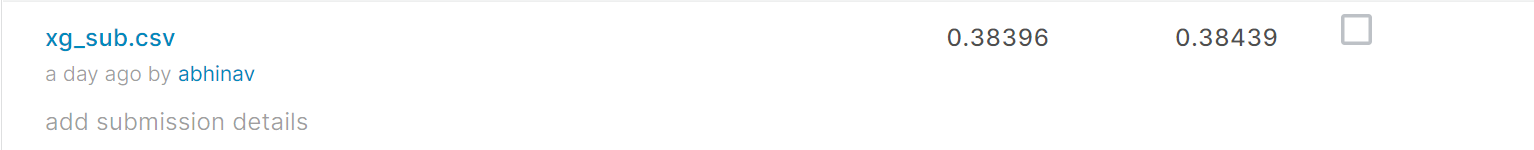

In [112]:
get_sub(final_xg,'xg_')                                      # xg boost              # 621 in leaderboard
i(filename="C:/Users/Abhi/Desktop/2.png")

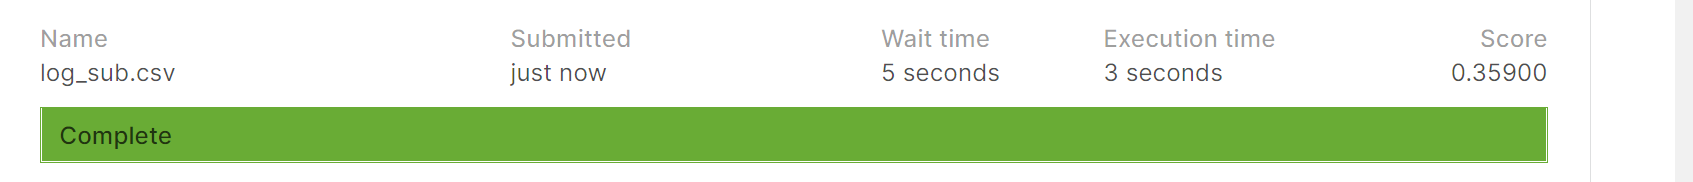

In [296]:
get_sub(final,'log_')                               # log -reg
i(filename="C:/Users/Abhi/Desktop/3.png")

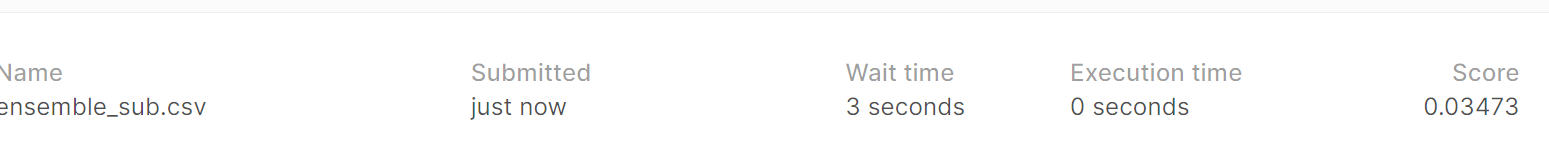

In [196]:
get_sub(final_ensemble,'ensemble_')                               # ensemble
i(filename="C:/Users/Abhi/Desktop/4.png")